# Определение перспективного тарифа для компании "Мегалайн"

**Заказчик** компания «Мегалайн» — федеральный оператор сотовой связи.
Компания предлагает два тарифных плана: «Смарт» и «Ультра»:

**1. Тариф «Смарт»**
Ежемесячная плата: 550 рублей. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика.

Стоимость услуг сверх тарифного пакета:

    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

**2. Тариф «Ультра»**
Ежемесячная плата: 1950 рублей. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика.

Стоимость услуг сверх тарифного пакета:

    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

**Важная особенность: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.**

**Цель компании** - скорректировать рекламный бюджет. Коммерческий департамент хочет понять, какой тариф приносит больше денег.

**Входные данные** - информация о 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

Необходимо:
1. Сделать предварительный анализ основных показателей и доходов тарифов на небольшой выборке клиентов
2. Проанализировать активность клиентов и сделать вывод — какой тариф лучше.


## Обзор данных

Для начала импортируем необходимые в работе библиотеки.

In [1]:
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

Заказчик передал информацию в 5 таблицах, сохраним их.

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv', index_col=0)
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')


C помощью функции `info()` посмотрим общую информацию об исходных данных.

In [3]:
def table_info(table):
    display(table.head())
    display(table.info(memory_usage='deep'))
    
table_info(calls)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6 MB


None

Таблица **calls** содержит 4 столбца и 202607 строк, пропущенные значения отсутствуют. В ней присутствуют два параметра типа `object`, и по одному `float` и `int`. Всего занимает 28,6 МВ памяти. Сразу видим, что есть нулевое значение параметра **duration**, возможно таким образом учитываются пропущенные звонки.


**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [4]:
table_info(internet)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 22.2 MB


None

Таблица **internet** содержит 4 столбца и 149396 строк, пропущенные значения отсутствуют. В ней присутствуют два параметра типа `object`, и по одному `float` и `int`. Всего занимает 22,2 МВ памяти. 

**Таблица internet (информация об интернет-сессиях):**
id — уникальный номер сессии
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
session_date — дата интернет-сессии
user_id — идентификатор пользователя

In [5]:
table_info(messages)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 16.4 MB


None

Таблица **messages** содержит 3 столбца и 123036 строк, пропущенные значения отсутствуют. В ней присутствуют два параметра типа `object` и один типа`int`. Всего занимает 16,4 МВ памяти. 

Таблица messages (информация о сообщениях): 
- id — уникальный номер сообщения 
- message_date — дата сообщения 
- user_id — идентификатор пользователя, отправившего сообщение

In [6]:
table_info(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 364.0 bytes


None

Таблица **tariffs** содержит 8 столбцов и всего 2 строки, пропущенные значения отсутствуют. В ней присутствуют семь параметров типа `int` и один типа `object`. Всего занимает 364,0 bytes памяти. 

Таблица tariffs (информация о тарифах): 
- tariff_name — название тарифа 
- rub_monthly_fee — ежемесячная абонентская плата в рублях 
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату 
- messages_included — количество сообщений в месяц, включённых в абонентскую плату 
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах) 
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата) 
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета 
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [7]:
table_info(users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 229.6 KB


None

Таблица **users** содержит 8 столбцов и 500 строк. В параметре `churn_date` достаточно много пропущенных значений, это говорит что только 38 из 500 пользователей прекратили пользоваться тарифом. В ней присутствуют шесть параметров типа `object` и два типа`int`. Всего занимает 229,6 KB памяти. 

Таблица users (информация о пользователях): 
- user_id — уникальный идентификатор пользователя 
- first_name — имя пользователя 
- last_name — фамилия пользователя age — возраст пользователя (годы) 
- reg_date — дата подключения тарифа (день, месяц, год) 
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных) 
- city — город проживания пользователя 
- tariff — название тарифного плана

С данными ознакомились, перейдем к предобработке.

## Предобработка данных

### Изменение типов данных

Пройдем по порядку по всем таблица и изменим тип данных там, где это необходимо. Начнем с таблицы о звонках **calls**.

In [8]:
calls.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6 MB


Параметр id переведем из типа `object` в тип `int`. Для этого заменим в параметре **id** символ `_` и проверим, сколько уникальных значений у нас осталось.

In [9]:
print('Количество уникальных значений id до замены:',len(calls['id'].unique()))
display(calls.query('user_id == 1499').head())

calls['id'] = calls['id'].str.replace('_', '')

print('Количество уникальных значений id после замены:',len(calls['id'].unique()))
display(calls.query('user_id == 1499').head())

Количество уникальных значений id до замены: 202607


,id,call_date,duration,user_id
202387,1499_0,2018-12-09,0.00,1499
202388,1499_1,2018-10-03,0.00,1499
202389,1499_2,2018-11-19,12.50,1499
202390,1499_3,2018-11-27,9.65,1499
202391,1499_4,2018-11-17,17.55,1499


Количество уникальных значений id после замены: 202607


,id,call_date,duration,user_id
202387,14990,2018-12-09,0.00,1499
202388,14991,2018-10-03,0.00,1499
202389,14992,2018-11-19,12.50,1499
202390,14993,2018-11-27,9.65,1499
202391,14994,2018-11-17,17.55,1499


Количество уникальных значений не изменилось. Посмотрим, какие минимальные и максимальные значения принимают данные.

In [10]:
display(calls.agg(['min','max']))
print('Максимальное количество строк с user_id:',calls.groupby('user_id')['user_id'].count().max())

,id,call_date,duration,user_id
min,10000,2018-01-01,0.0,1000
max,149999,2018-12-31,38.0,1499


Максимальное количество строк с user_id: 1760


Изменим тип данных параметра **id** на `int32`, **call_date** переведем в формат даты, **duration** на `float32` и **user_id** на `int16`

In [11]:
#изменяет тип данных на 'int32'
calls['id'] = calls['id'].astype('int32')

#изменяет тип данных на 'datetime64'
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')

#изменяет тип данных на 'float32'
calls['duration'].astype('float32')

#изменяет тип данных на 'int16'
calls['user_id'].astype('int16')

calls.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  int32         
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1)
memory usage: 5.4 MB


Таким образом, мы снизили потребление памяти с 28.6 до 5.4 MB.

Рассмотрим таблицу **internet**.

In [12]:
display(internet.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 22.2 MB


None

Посмотрим, какие минимальные и максимальные значения принимают данные.

In [13]:
display(internet.agg(['min','max']))
print('Максимальное количество строк с user_id:',internet.groupby('user_id')['user_id'].count().max())

,id,mb_used,session_date,user_id
min,1000_0,0.00,2018-01-01,1000
max,1499_99,1724.83,2018-12-31,1499


Максимальное количество строк с user_id: 834


Обратим внимание, что минимальное значение параметра **mb_used** - 0, возможно это говорит о том, что интернет трафик не был использован. Проанализируем эти значения позже.

Изменим тип данных параметра **id** на `int32`, **session_date** переведем в формат даты, **mb_used** на `float32` и **user_id** на `int16`.

In [14]:
#изменяет тип данных на 'int32'
internet['id'] = internet['id'].str.replace('_', '').astype('int32')

#изменяет тип данных на 'datetime64'
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y-%m-%d')

#изменяет тип данных на 'float32'
internet['mb_used'].astype('float32')

#изменяет тип данных на 'int16'
internet['user_id'].astype('int16')

internet.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  int32         
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1)
memory usage: 5.1 MB


Таким образом, мы снизили потребление памяти с 22.2 до 5.1 MB. 

Рассмотрим таблицу **messages**.

In [15]:
display(messages.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 16.4 MB


None

Посмотрим, какие минимальные и максимальные значения принимают данные.

In [16]:
display(messages.agg(['min','max']))
print('Максимальное количество строк с user_id:',messages.groupby('user_id')['user_id'].count().max())

,id,message_date,user_id
min,1000_0,2018-01-02,1000
max,1499_99,2018-12-31,1499


Максимальное количество строк с user_id: 1463


Изменим тип данных параметра **id** на `int32`, **message_date** переведем в формат даты и изменим **user_id** на `int16`.

In [17]:
#изменяет тип данных на 'int32'
messages['id'] = messages['id'].str.replace('_', '').astype('int32')

#изменяет тип данных на 'datetime64'
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y-%m-%d')

#изменяет тип данных на 'int16'
messages['user_id'].astype('int16')

messages.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  int32         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 2.3 MB


Таким образом, мы снизили потребление памяти с 16.4  до 2.3 MB. 

Рассмотрим таблицу **tariffs**.

In [18]:
display(tariffs.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 364.0 bytes


None

Данные занимают всего 364.0 bytes, поэтому типы оставим без изменения.

Рассмотрим таблицу **users**.

In [19]:
display(users.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 229.6 KB


None

Переведем параметр **reg_date** в формат даты, а остальные параметры оставим без изменения из-за небольшого потребления памяти.

In [20]:
#изменяет тип данных на 'datetime64'
users['reg_date'] = pd.to_datetime(users['reg_date'],format='%Y-%m-%d')

users.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 200.8 KB


Посмотрим на пропущенные значения в таблице.

In [21]:
users['churn_date'].unique()

array([nan, '2018-10-05', '2018-12-18', '2018-11-21', '2018-10-03',
       '2018-10-14', '2018-12-09', '2018-12-11', '2018-12-26',
       '2018-08-31', '2018-12-03', '2018-12-23', '2018-11-07',
       '2018-12-16', '2018-12-20', '2018-11-30', '2018-12-21',
       '2018-08-17', '2018-09-02', '2018-10-04', '2018-11-13',
       '2018-11-22', '2018-10-28', '2018-11-26', '2018-11-27',
       '2018-11-16', '2018-10-27', '2018-12-30', '2018-09-27',
       '2018-12-25', '2018-12-14', '2018-12-24', '2018-09-26',
       '2018-10-25'], dtype=object)

Пропущенные значения заменим на "активный".

In [22]:
users['churn_date'] = users['churn_date'].fillna('активный')
users.info(memory_usage='deep')
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  500 non-null    object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 230.6 KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,активный,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,активный,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,активный,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,активный,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,активный,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Промежуточные результаты.
- Cнизили потребление памяти таблице **calls** с 28.6 до 5.4 MB, изменив тип данных параметров:
    - **id** на `int32`, 
    - **duration** на `float32`,
    - **user_id** на `int16`,
    - **call_date** перевели в формат даты.
    
    
- Cнизили потребление памяти таблице **internet** с 22.2 до 5.1 MB, изменив тип данных параметров:
    - **id** на `int32`, 
    - **mb_used** на `float32`,
    - **user_id** на `int16`,
    - **session_date** переведли в формат даты.
    
    
- Cнизили потребление памяти таблице **messages** с 16.4 до 2.3 MB, изменив тип данных параметров:
    - **id** на `int32`, 
    - **user_id** на `int16`,
    - **message_date** перевели в формат даты.


- Таблицу **tariffs** оставили без изменений из-за потребления небольшого количества памяти.


- В таблице **users** параметр **reg_date** перевели в формат даты, пропуски в параметре **churn_date** заменили на "активные".

### Анализ исходных данных и подготовка их к исследованию

Как было замечено при предварительном анализе, в данных есть "нулевые" значения в параметрах длительности звонков **duration** и интернет-трафика **mb_used**. А также необходимо рассмотреть параметр **churn_date**, определяющих пользователей, которые отказались от тарифа.

Сначала добавим во все таблицы с датами звонка, использования тарифа, отправки сообщения и датой регистрации параметр месяц. А также округлим вверх израсходованные минуты и мегабайты в соответствие с регламентом компании.

In [23]:
#добавляет параметр с месяцем 
#даты звонка, использования трафика, отправки сообщения, регистрации пользователя
calls['call_date_month'] = pd.DatetimeIndex(calls['call_date']).month
internet['session_date_month'] = pd.DatetimeIndex(internet['session_date']).month
messages['message_date_month'] = pd.DatetimeIndex(messages['message_date']).month
users['reg_date_month'] = pd.DatetimeIndex(users['reg_date']).month

#округляет количество минут вверх для параметра 'duration'
calls['duration'] = np.ceil(calls['duration']).astype('int')
display(calls.head())

#округляет количество МВ вверх для параметра 'duration'
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int')
display(internet.head())

,id,call_date,duration,user_id,call_date_month
0,10000,2018-07-25,0,1000,7
1,10001,2018-08-17,0,1000,8
2,10002,2018-06-11,3,1000,6
3,10003,2018-09-21,14,1000,9
4,10004,2018-12-15,6,1000,12


,id,mb_used,session_date,user_id,session_date_month
0,10000,113,2018-11-25,1000,11
1,10001,1053,2018-09-07,1000,9
2,10002,1198,2018-06-25,1000,6
3,10003,551,2018-08-22,1000,8
4,10004,303,2018-09-24,1000,9


Посмотрим, какую долю составляют "нулевые" звонки.

In [24]:
print('Доля "нулевых" звонков: {:.1%}'.format(len(calls.query('duration == 0'))/len(calls)))

Доля "нулевых" звонков: 19.6%


Достаточно большая доля. Сгруппируем данные по звонкам в разрезе пользователя (user_id) и месяца (call_date_month), добавим количество "нулевых" звонков и их долю в общем количестве звонков.

In [25]:
#группирует "нулевые" звонки в разрезе пользователя и месяца
calls_null = calls.query('duration == 0').pivot_table(index=['user_id', 'call_date_month'], 
                              values = 'duration',
                              aggfunc = 'count')

#группирует все звонки в разрезе пользователя и месяца
calls_stat = calls.pivot_table(index=['user_id', 'call_date_month'], 
                              values = 'duration',
                              aggfunc = ['count','sum'])

#добавляет в таблицу calls_stat данные о "нулевых" звонках и переименовывает колонки
calls_stat = calls_stat.merge(calls_null, on=['user_id', 'call_date_month'], how='left')
calls_stat.columns = ['count_calls', 'duration', 'count_null_calls']

#заполняет NaN в количестве "нулевых" звонков на 0
calls_stat['count_null_calls'] = calls_stat['count_null_calls'].fillna(0)

#считает долю "нулевых" звонков в общем количестве звонков
calls_stat['part_null_in_calls'] = (calls_stat['count_null_calls'] / calls_stat['count_calls'])

#повторяет значение индекса и переименовывает 'call_date_month' на 'month'
calls_stat = calls_stat.reset_index()
calls_stat = calls_stat.rename(columns={'call_date_month': 'month'})

calls_stat.head()

,user_id,month,count_calls,duration,count_null_calls,part_null_in_calls
0,1000,5,22,159,5.0,0.227273
1,1000,6,43,172,15.0,0.348837
2,1000,7,47,340,6.0,0.127660
3,1000,8,52,408,10.0,0.192308
4,1000,9,58,466,12.0,0.206897


Посмотрим, остались ли "нулевые" звонки в разрезе месяцов.

In [26]:
display(calls_stat.query('duration == 0'))

,user_id,month,count_calls,duration,count_null_calls,part_null_in_calls
1493,1240,2,2,0,2.0,1.0
1605,1257,7,1,0,1.0,1.0
1606,1257,8,2,0,2.0,1.0
1607,1257,9,1,0,1.0,1.0
2318,1373,1,2,0,2.0,1.0
2321,1373,4,1,0,1.0,1.0


Есть трое пользователей, которые в течении месяца не совершали звонков. 

Посмотрим на активность данные пользователи в другое время, для этого сгруппируем все данные по пользователям и посмотрим общую статистику за год.

А также посмотри информацию по ним в таблице **users**.

In [27]:
#выводит информацию о пользователях
display(users.query('user_id == 1240 or user_id == 1257 or user_id == 1373'))

#выводит активность пользователей за весь год
calls_null_all_month = calls_stat.query('duration == 0')['user_id']
calls_stat.query('user_id in @calls_null_all_month').pivot_table(index='user_id',
                aggfunc = {'month':'count','part_null_in_calls':'mean',
                           'count_calls':'sum','duration':'sum','count_null_calls':'sum'})


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_date_month
240,1240,30,активный,Воронеж,Зинаида,Шарова,2018-02-27,ultra,2
257,1257,21,активный,Санкт-Петербург,Габриель,Жданов,2018-06-17,ultra,6
373,1373,34,активный,Улан-Удэ,Нелли,Афанасенко,2018-01-17,smart,1


,count_calls,count_null_calls,duration,month,part_null_in_calls
user_id,,,,,
1240,572,116.0,4145,11,0.271857
1257,14,7.0,66,7,0.595238
1373,24,7.0,136,11,0.271212


Как видим, у пользователя с user_id №1240 "нулевые" звонки были в первом месяце использования тарифа, в остальное время он вел себя достаточно активно. А вот у двух остальных звонков гораздо меньше, а у №1257 даже больше 50%. Возможно они активно используют интернет или сообщения. Данные по ним оставляем без изменения.

Посмотрим, как распределяется доля пропущенных звонков среди остальных пользователей.

count    3174.000000
mean        0.196500
std         0.074104
min         0.000000
25%         0.158537
50%         0.194444
75%         0.228571
max         1.000000
Name: part_null_in_calls, dtype: float64

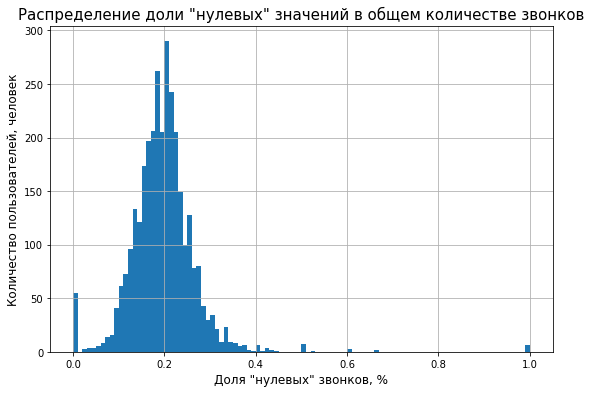

In [28]:
#выводит описание распределения
display(calls_stat['part_null_in_calls'].describe())

#выводит гистограмму
calls_stat['part_null_in_calls'].hist(figsize=(9,6), bins=100)

#Добавляет название заголовка, осей и устанавливает ограничения значений оси y
plt.title('Распределение доли "нулевых" значений в общем количестве звонков', fontsize=15)
plt.xlabel('Доля "нулевых" звонков, %', fontsize=12)
plt.ylabel('Количество пользователей, человек', fontsize=12)
plt.show()

Видим, что в среднем доля "нулевых" звонков составялет около 20%. Есть небольшой пик в районе 0, сформированный нами при заполнении NaN значений, что, возможно, говорит об отсутствие пропущенных звонков. А также в районе 1, который рассмотрели уже выше.

Посмотрим на расспределение количества звонков с "нулевыми" значениями и без.

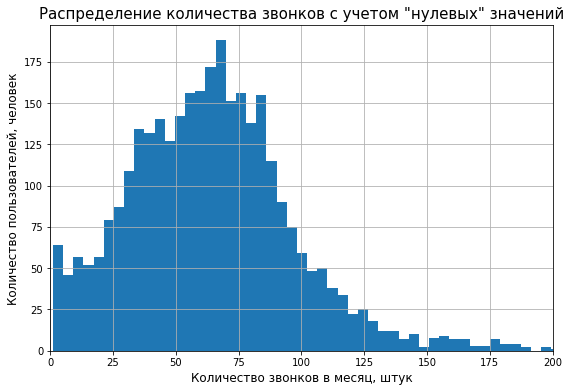

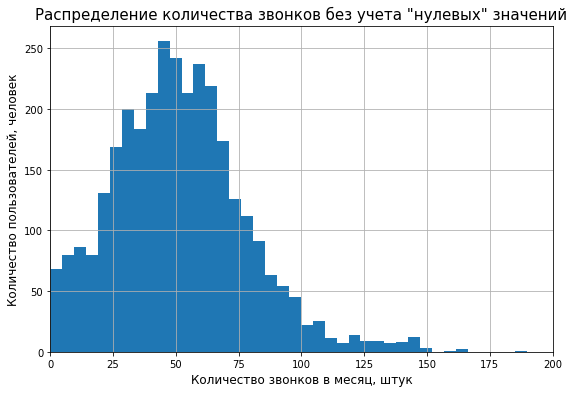

In [29]:
#считает количество звонков без учета "нулевых"
calls_stat['count_without_null'] = (calls_stat['count_calls'] - calls_stat['count_null_calls'])

#распределение количества звонков с учетом "нулевых" значений
calls_stat['count_calls'].hist(figsize=(9,6), bins=60)
#Добавляет название заголовка, осей и устанавливает ограничения значений оси y
plt.title('Распределение количества звонков с учетом "нулевых" значений', fontsize=15)
plt.xlabel('Количество звонков в месяц, штук', fontsize=12)
plt.ylabel('Количество пользователей, человек', fontsize=12)
plt.xlim(0,200)
plt.show()

#распределение количества звонков без учета "нулевых" значений
calls_stat['count_without_null'].hist(figsize=(9,6), bins=40)
#Добавляет название заголовка, осей и устанавливает ограничения значений оси y
plt.title('Распределение количества звонков без учета "нулевых" значений', fontsize=15)
plt.xlabel('Количество звонков в месяц, штук', fontsize=12)
plt.ylabel('Количество пользователей, человек', fontsize=12)
plt.xlim(0,200)
plt.show()

Как видим, вид распределения не изменяется, а вот структура распределения меняется, среднее и медиана смещаются влево. Посмотрим с помощью метода `describe`.

In [30]:
calls_stat_object = ['count_calls','count_without_null']
for column in calls_stat_object:
    display(calls_stat[column].to_frame().describe())

,count_calls
count,3174.000000
mean,63.833333
std,32.678036
min,1.000000
25%,41.000000
50%,63.000000
75%,83.000000
max,244.000000


,count_without_null
count,3174.000000
mean,51.352867
std,26.508582
min,0.000000
25%,33.000000
50%,50.000000
75%,67.000000
max,190.000000


С учетом "нулевых" звонков среднее количество звонков в месяц составляет почти 64, а вот без учета "нулевых" звонков - 51. Нас интересуют исходящие звонки, именно они учитываются в тарифе и именно за сверхтарифные исходящие минуты взимается плата. Поэтому "нулевые" звонки не будем учитывать в нашем анализе. 

Сформируем исходную таблицу calls_net с количеством сделанных звонков и суммой израсходованных минут разговора по месяцам в разрезе пользователей.

In [31]:
#группирует все не "нулевые" звонки в разрезе пользователя и месяца
calls_net = calls.query('duration > 0').pivot_table(index=['user_id', 'call_date_month'], 
                                                          values = 'duration',
                                                          aggfunc = ['count','sum'])

#повторяет значение индекса и переименовывает столбцы
calls_net = calls_net.reset_index()
calls_net.columns = ['user_id','month','count_calls', 'duration_calls']

calls_net.head()

,user_id,month,count_calls,duration_calls
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466


Теперь посмотрим, какую долю составляют "нулевой" интернет-трафик.

In [32]:
print('Доля "нулевого" интернет-трафика: {:.1%}'.format(len(internet.query('mb_used == 0'))/len(internet)))

Доля "нулевого" интернет-трафика: 13.1%


Сгруппируем данные по интернет-трафику в разрезе пользователя (user_id) и месяца (call_date_month), добавим количество "нулевого" интернет-трафика и его долю в общем трафике.

In [33]:
#группирует "нулевой" интернет-трафик  в разрезе пользователя и месяца
internet_null = internet.query('mb_used == 0').pivot_table(index=['user_id', 'session_date_month'], 
                              values = 'mb_used',
                              aggfunc = 'count')

#группирует весь интернет-трафик в разрезе пользователя и месяца
internet_stat = internet.pivot_table(index=['user_id', 'session_date_month'], 
                              values = 'mb_used',
                              aggfunc = ['count','sum'])

#добавляет в таблицу internet_stat данные о "нулевом" интернет-трафике и переименовывает колонки
internet_stat = internet_stat.merge(internet_null, on=['user_id', 'session_date_month'], how='left')
internet_stat.columns = ['count_mb', 'mb_used', 'count_mb_null']

#заполняет NaN в количестве "нулевого" интернет-трафика на 0
internet_stat['count_mb_null'] = internet_stat['count_mb_null'].fillna(0)

#считает долю "нулевого" интернет-трафика в общем интернет-трафике
internet_stat['part_null_in_mb'] = (internet_stat['count_mb_null'] / internet_stat['count_mb'])

#повторяет значение индекса и переименовывает 'session_date_month' на 'month'
internet_stat = internet_stat.reset_index()
internet_stat = internet_stat.rename(columns={'session_date_month': 'month'})

internet_stat.head()

,user_id,month,count_mb,mb_used,count_mb_null,part_null_in_mb
0,1000,5,5,2256,1.0,0.200000
1,1000,6,49,23257,5.0,0.102041
2,1000,7,29,14016,1.0,0.034483
3,1000,8,29,14070,2.0,0.068966
4,1000,9,27,14581,2.0,0.074074


Посмотрим, остались ли пользователи, не использовавшие в течении месяца интернет-трафик.

In [34]:
internet_stat.query('mb_used == 0')

,user_id,month,count_mb,mb_used,count_mb_null,part_null_in_mb
592,1094,5,1,0,1.0,1.0
2298,1365,10,1,0,1.0,1.0


Есть двое пользователей, которые в течении месяца ни разу не воспользовались интернетом. Посмотрим информацию о них и их активность в целом за год.

In [35]:
#выводит информацию о пользователях
display(users.query('user_id == 1094 or user_id == 1365'))

#выводит активность пользователей за весь год
internet_null_all_month = internet_stat.query('mb_used == 0')['user_id']
internet_stat.query('user_id in @internet_null_all_month').pivot_table(index='user_id',
                aggfunc = {'month':'count','part_null_in_mb':'mean',
                           'count_mb':'sum','count_mb_null':'sum','mb_used':'sum'})

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_date_month
94,1094,37,активный,Новосибирск,Даниэла,Пугачева,2018-05-28,ultra,5
365,1365,38,активный,Ростов-на-Дону,Георгий,Вишняков,2018-10-31,smart,10


,count_mb,count_mb_null,mb_used,month,part_null_in_mb
user_id,,,,,
1094,299,13.0,144469,8,0.158348
1365,169,28.0,54158,3,0.440909


Можем отметить, что "нулевой" интернет-трафик наблюдается у двух пользователей, подключившихся к тарифу в конце рассматриваемого месяца. В остальное время пользователи активно пользуются интернетом.

Посмотрим, как распределяется доля пропущенных звонков среди остальных пользователей.

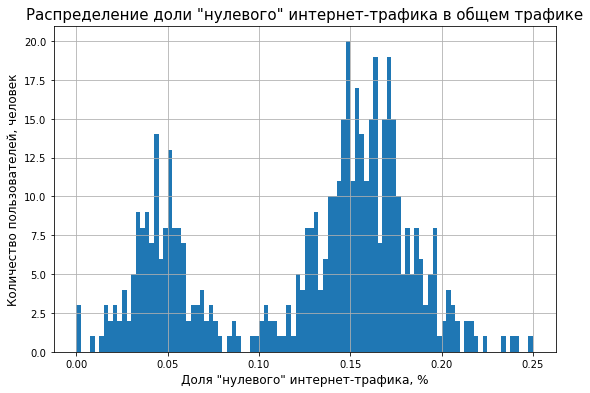

In [36]:
#формирует общую таблицу за год в разрезе пользователей
internet_stat_group_users = internet_stat.groupby('user_id')[['count_mb','count_mb_null','mb_used']].sum()

#рассчитывает долю нулевого интернет-трафика
internet_stat_group_users['part_null_in_mb'] = (internet_stat_group_users['count_mb_null'] / 
                                                internet_stat_group_users['count_mb'])

#выводит гистограмму
internet_stat_group_users['part_null_in_mb'].hist(bins=100, figsize=(9,6))

#Добавляет название заголовка, осей и устанавливает ограничения значений оси y
plt.title('Распределение доли "нулевого" интернет-трафика в общем трафике', fontsize=15)
plt.xlabel('Доля "нулевого" интернет-трафика, %', fontsize=12)
plt.ylabel('Количество пользователей, человек', fontsize=12)
plt.show()

На гистограмме два пика, возможно это связано с тарифом.

Добавим тарифный план и построим гистограмму.

In [37]:
#добавляет тарифный план в таблицу internet_stat_group_users
users_tariff = users[['user_id','tariff']]
internet_stat_group_users = internet_stat_group_users.merge(users_tariff, on='user_id', how='left')
internet_stat_group_users.head()

,user_id,count_mb,count_mb_null,mb_used,part_null_in_mb,tariff
0,1000,211,14.0,107492,0.066351,ultra
1,1001,96,14.0,32505,0.145833,smart
2,1002,369,72.0,116183,0.195122,smart
3,1003,104,2.0,57329,0.019231,ultra
4,1004,300,22.0,149172,0.073333,ultra


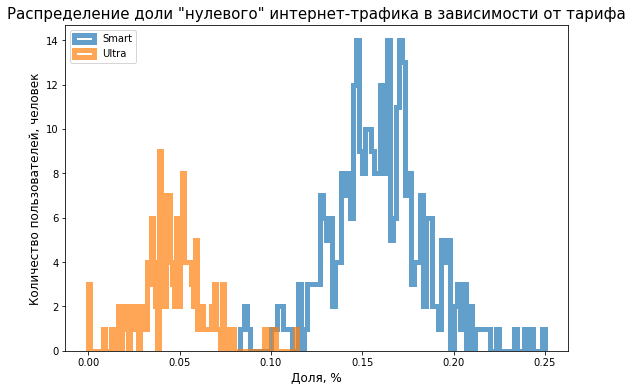

In [38]:
ax = internet_stat_group_users.query('tariff == "smart"').plot(kind='hist',
                                                               y='part_null_in_mb',
                                                               histtype='step',
                                                               figsize=(9,6),
                                                               bins=100,
                                                               linewidth=5,
                                                               alpha=0.7,
                                                               label='Smart')

internet_stat_group_users.query('tariff == "ultra"').plot(kind='hist',
                                                          y='part_null_in_mb',
                                                          histtype='step',
                                                          figsize=(9,6),
                                                          bins=100,
                                                          ax=ax,
                                                          linewidth=5,
                                                          alpha=0.7,
                                                          label='Ultra')


plt.title('Распределение доли "нулевого" интернет-трафика в зависимости от тарифа', fontsize=15)
plt.xlabel('Доля, %', fontsize=12)
plt.ylabel('Количество пользователей, человек', fontsize=12)
plt.show()

Действительно, пики вызваны тарифным планом. Посмотрим в разрезе одного пользователя и одного месяца интернет-сессии. Для этого добавим параметр день месяца "session_date_day".

In [39]:
internet['session_date_day'] = pd.DatetimeIndex(internet['session_date']).day
internet.query('user_id == 1000 and session_date_month == 7').sort_values(by='session_date_day')

,id,mb_used,session_date,user_id,session_date_month,session_date_day
22,100022,724,2018-07-02,1000,7,2
192,1000192,790,2018-07-02,1000,7,2
172,1000172,641,2018-07-04,1000,7,4
57,100057,479,2018-07-04,1000,7,4
42,100042,559,2018-07-06,1000,7,6
86,100086,717,2018-07-07,1000,7,7
154,1000154,185,2018-07-07,1000,7,7
144,1000144,134,2018-07-08,1000,7,8
130,1000130,522,2018-07-09,1000,7,9
82,100082,617,2018-07-10,1000,7,10


Как видим, нулевые значения интернет-трафика  появляются даже тогда, когда в этот день был использован трафик. Можно сделать предположение, что это связано с какими-то техническими процессами. 
Так как нулевые значения интернет-трафика не влияют на итоговую сумму, то данные оставим.

Сформируем итоговую таблицу internet_net.

In [40]:
#группирует весь интернет-трафик в разрезе пользователя и месяца
internet_net = internet.pivot_table(index=['user_id', 'session_date_month'], 
                                    values = 'mb_used',
                                    aggfunc = 'sum')

#повторяет значение индекса и переименовывает столбцы
internet_net = internet_net.reset_index()
internet_net = internet_net.rename(columns={'session_date_month': 'month'})

internet_net.head()


,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


Сгруппируем данные по количеству cообщений в разрезе пользователя (user_id) и месяца (message_date_month).

In [41]:
#группирует сообщения в разрезе пользователя и месяца
messages_net = messages.pivot_table(index=['user_id', 'message_date_month'], 
                              values = 'id',
                              aggfunc = 'count')


#повторяет значение индекса и переименовывает 'message_date_month' на 'month'
messages_net = messages_net.reset_index()
messages_net = messages_net.rename(columns={'message_date_month': 'month', 'id':'message_count'})

messages_net.info()
messages_net.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        2717 non-null   int64
 1   month          2717 non-null   int64
 2   message_count  2717 non-null   int64
dtypes: int64(3)
memory usage: 63.8 KB


,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Сведем все данные о звонках, сообщениях и интернете в одну таблицу.

In [42]:
stat = calls_net.merge(internet_net, on=['user_id', 'month'], how='outer')
stat = stat.merge(messages_net, on=['user_id', 'month'], how='outer')

display(stat.head())
stat.info()

,user_id,month,count_calls,duration_calls,mb_used,message_count
0,1000,5,17.0,159.0,2256.0,22.0
1,1000,6,28.0,172.0,23257.0,60.0
2,1000,7,41.0,340.0,14016.0,75.0
3,1000,8,42.0,408.0,14070.0,81.0
4,1000,9,46.0,466.0,14581.0,57.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   month           3214 non-null   int64  
 2   count_calls     3168 non-null   float64
 3   duration_calls  3168 non-null   float64
 4   mb_used         3203 non-null   float64
 5   message_count   2717 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


У нас есть пропущенные значения в параметрах **count_calls, duration_calls, mb_used и message_count**, это означает что в данном периоде пользователь ни разу не воспользовался данной  услугой. Заменим их на 0.

In [43]:
for column in ['count_calls', 'duration_calls', 'mb_used', 'message_count']:
    stat[column] = stat[column].fillna(0)
    
stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   month           3214 non-null   int64  
 2   count_calls     3214 non-null   float64
 3   duration_calls  3214 non-null   float64
 4   mb_used         3214 non-null   float64
 5   message_count   3214 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


Теперь посмотрим на пользователей, которые отказались от тарифа. Сохраним их в **users_out**, переведем в формат даты параметр **churn_date** и посчитаем, сколько прошло дней с момента регистрации до момента отказа от тарифа **delta_in_off**.

In [44]:
#сохраняет в 'users_out' всех пользователей, прекративших использовать тарифный план
users_out = pd.DataFrame(users.query('churn_date != "активный"'))

#переводит в формат даты
users_out['churn_date'] = pd.to_datetime(users_out['churn_date'],format='%Y-%m-%d')

#создает параметр, показывающий сколько прошло дней с момента регистрации до момента закрытия тарифа
users_out['delta_in_off'] = (users_out['churn_date'] - users_out['reg_date']).dt.days

print('Количетсво ушедших пользователей - {} человек, их доля среди всех пользователей - {:.1%}'.format(
    len(users_out), len(users_out)/len(users)))
print('Среднее количество дней использования тарифа {:.0f} дней'.format(users_out['delta_in_off'].mean()))

display(users_out.sort_values(by='delta_in_off'))


Количетсво ушедших пользователей - 38 человек, их доля среди всех пользователей - 7.6%
Среднее количество дней использования тарифа 124 дней


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_date_month,delta_in_off
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,12,5
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12,8
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart,11,23
242,1242,39,2018-12-21,Хабаровск,Радим,Федосеев,2018-11-18,smart,11,33
163,1163,21,2018-12-16,Москва,Лев,Вишневский,2018-11-03,smart,11,43
206,1206,35,2018-12-20,Москва,Елена,Шарапова,2018-11-03,smart,11,47
399,1399,31,2018-12-25,Уфа,Алиса,Абрашина,2018-11-06,ultra,11,49
90,1090,54,2018-12-03,Череповец,Екатерина,Астафьева,2018-10-11,ultra,10,53
232,1232,60,2018-11-30,Томск,Виктория,Ларина,2018-10-07,smart,10,54
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart,10,57


Есть трое клиентов, которые использовали тариф меньше месяца и отключились. Но в среднем ушедшие клиенты пользовались услугами компании в течении 4-х месяцев.

Создадим параметр активности и сравним показатели ушедших и активных клиентов.

In [45]:
def active(row):
    churn_date = row['churn_date']
    
    if churn_date == 'активный':
        return 'активный'
    else:
        return 'ушел'
    
users['active'] = users.apply(active, axis=1)

users.tail()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_date_month,active
495,1495,65,активный,Иркутск,Авксентий,Фокин,2018-08-28,ultra,8,активный
496,1496,36,активный,Вологда,Трифон,Блохин,2018-01-27,smart,1,активный
497,1497,32,активный,Челябинск,Каролина,Агеева,2018-10-09,smart,10,активный
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,7,ушел
499,1499,35,активный,Пермь,Гектор,Корнилов,2018-09-27,smart,9,активный


Создадим таблицу **users_stat** и добавим информацию о пользователях, а также о количестве использованных звонках, сообщениях и интернете клиентом в среднем за месяц. 
Так как, как правило, исследуемые показатели в первый месяц использования тарифа значительно ниже, чем в остальной период, тов качестве среднего значения возьмем медиану.

In [46]:
#добавляет информацию об использованных звонках, сообщениях и интернете 
#пользователем в среднем за месяц
users_stat = users.merge(
    stat.groupby('user_id')['count_calls','duration_calls','mb_used','message_count'].median(), 
    on='user_id', 
    how='left')

#добавляет количество месяцев, в течении которого клиент пользовался тарифом
users_stat = users_stat.merge(
    stat.groupby('user_id')['month'].count(), 
    on='user_id', 
    how='left')

users_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         500 non-null    int64         
 1   age             500 non-null    int64         
 2   churn_date      500 non-null    object        
 3   city            500 non-null    object        
 4   first_name      500 non-null    object        
 5   last_name       500 non-null    object        
 6   reg_date        500 non-null    datetime64[ns]
 7   tariff          500 non-null    object        
 8   reg_date_month  500 non-null    int64         
 9   active          500 non-null    object        
 10  count_calls     498 non-null    float64       
 11  duration_calls  498 non-null    float64       
 12  mb_used         498 non-null    float64       
 13  message_count   498 non-null    float64       
 14  month           498 non-null    float64       
dtypes: dat

Появились пропущенные значения. Посмотри, что они в себе содержат.

In [47]:
users_stat[users_stat['month'].isnull()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_date_month,active,count_calls,duration_calls,mb_used,message_count,month
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12,ушел,NaN,NaN,NaN,NaN,NaN
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,12,ушел,NaN,NaN,NaN,NaN,NaN


Это клиенты, которые подключали тариф всего на несколько дней. Пакетом услуг они не воспользовались, поэтому уберем их из анализа.

In [48]:
users_stat = users_stat[~users_stat['count_calls'].isnull()]
users_stat.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_date_month,active,count_calls,duration_calls,mb_used,message_count,month
0,1000,52,активный,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,активный,39.5,339.0,14325.5,65.0,8.0
1,1001,41,активный,Москва,Иван,Ежов,2018-11-01,smart,11,активный,46.0,422.0,16252.5,0.0,2.0
2,1002,59,активный,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,активный,25.0,214.0,17601.0,11.0,7.0
3,1003,23,активный,Москва,Белла,Белякова,2018-08-17,ultra,8,активный,95.0,824.0,11368.0,83.0,5.0
4,1004,68,активный,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,активный,18.0,132.5,17828.5,154.5,8.0


Посмотри количество активных и ушедших пользователей по каждому тарифу.

In [49]:
print('Количество активных пользователей тарифа "Smart" - {} человек.'.format( 
      users_stat.query('tariff == "smart" and churn_date == "активный"')['user_id'].count()))
print('Количество ушедших пользователей с тарифа "Smart" - {} человек.'.format( 
      users_stat.query('tariff == "smart" and churn_date != "активный"')['user_id'].count()))
print('Их доля {:.1%}'.format(
    (users_stat.query('tariff == "smart" and churn_date != "активный"')['user_id'].count()/
     users_stat.query('tariff == "smart" and churn_date == "активный"')['user_id'].count())))

print('')
print('Количество активных пользователей тарифа "Ultra" - {} человек.'.format( 
      users_stat.query('tariff == "ultra" and churn_date == "активный"')['user_id'].count()))
print('Количество ушедших пользователей с тарифа "Ultra" - {} человек.'.format( 
      users_stat.query('tariff == "ultra" and churn_date != "активный"')['user_id'].count()))
print('Их доля {:.1%}'.format(
    (users_stat.query('tariff == "ultra" and churn_date != "активный"')['user_id'].count()/
     users_stat.query('tariff == "ultra" and churn_date == "активный"')['user_id'].count())))



Количество активных пользователей тарифа "Smart" - 328 человек.
Количество ушедших пользователей с тарифа "Smart" - 22 человек.
Их доля 6.7%

Количество активных пользователей тарифа "Ultra" - 134 человек.
Количество ушедших пользователей с тарифа "Ultra" - 14 человек.
Их доля 10.4%


Видим, что основная масса пользователей имеет тариф "Smart", доля ушедших пользователей составляет 6,7%. А вот с тарифа "Ultra" ушло 10,4% пользователей.

Посмотрим на распределение основных среднемесячных показателей в разрезе каждого тарифа. Начнем с тарифа "Smart" - рассмотрим описание с помощью метода `describe` и построим графики.

In [50]:
actives = ['активный','ушел']

for active in actives:    
        
    subset = users_stat[((users_stat['active'] == active) & (users_stat['tariff'] == 'smart'))]

    if active == 'активный':
        print('Основные показатели активных клиентов тарифа "Smart":')
    else:
        print('Основные показатели ушедших клиентов тарифа "Smart":')
        
    display(subset[['count_calls','duration_calls','mb_used', 'message_count']].describe())

Основные показатели активных клиентов тарифа "Smart":


,count_calls,duration_calls,mb_used,message_count
count,328.000000,328.000000,328.000000,328.000000
mean,50.378049,445.518293,17067.103659,34.024390
std,18.088901,160.828811,4058.162262,28.281314
min,0.000000,0.000000,6040.000000,0.000000
25%,37.000000,329.500000,14344.125000,11.000000
50%,50.000000,451.250000,17143.500000,28.500000
75%,63.000000,551.250000,19566.875000,52.000000
max,104.000000,891.500000,36319.000000,134.000000


Основные показатели ушедших клиентов тарифа "Smart":


,count_calls,duration_calls,mb_used,message_count
count,22.000000,22.000000,22.000000,22.000000
mean,35.863636,317.454545,13674.090909,29.977273
std,10.516633,89.421941,4750.534753,23.845973
min,18.000000,159.000000,5545.000000,0.000000
25%,31.125000,282.250000,9343.500000,13.750000
50%,35.500000,326.500000,14302.750000,28.500000
75%,40.375000,349.375000,17015.250000,39.000000
max,54.500000,504.000000,22669.000000,103.000000


Как видим из описания методом `describe` средние значения ушедших пользователей меньше, чем активных.  
Построим гистограммы плотностей.

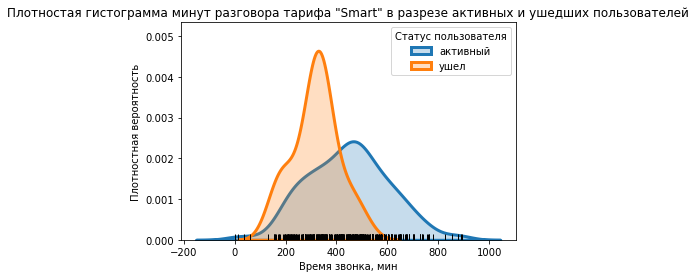

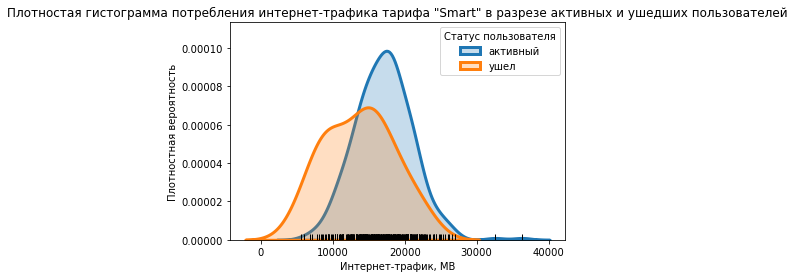

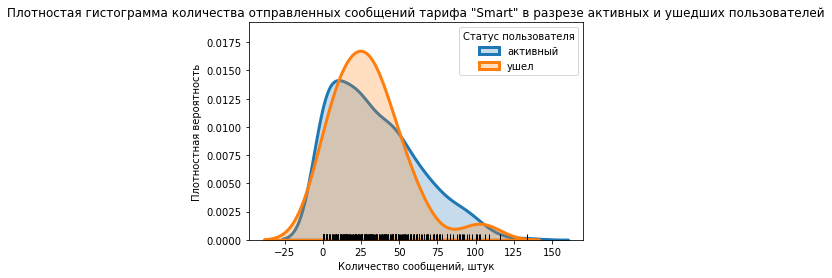

In [51]:
# Построение гистограммы плотностей по среднемесячному количеству минут разговора 
for active in actives:   
        
    # Формирует таблицу
    subset = users_stat[((users_stat['active'] == active) & (users_stat['tariff'] == 'smart'))]

    # Выводит гистограмму плотностей
    sns.distplot(subset['duration_calls'], hist = False, kde = True, rug=True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 rug_kws={'color': 'black'},
                 label = active)

# Выводит формат для гистограммы
plt.legend(title = 'Статус пользователя')
plt.title('Плотностая гистограмма минут разговора тарифа "Smart" в разрезе активных и ушедших пользователей')
plt.xlabel('Время звонка, мин')
plt.ylabel('Плотностная вероятность')
plt.show()

# Построение гистограммы плотностей по среднемесячному потреблению интернет-трафика 
for active in actives:   
        
    # Формирует таблицу
    subset = users_stat[((users_stat['active'] == active) & (users_stat['tariff'] == 'smart'))]

    # Выводит гистограмму плотностей
    sns.distplot(subset['mb_used'], hist = False, kde = True, rug=True,
                 kde_kws = {'shade': True,'linewidth': 3},
                 rug_kws={'color': 'black'},
                 label = active)

    
# Выводит формат для гистограммы
plt.legend(title = 'Статус пользователя')
plt.title('Плотностая гистограмма потребления интернет-трафика тарифа "Smart" в разрезе активных и ушедших пользователей')
plt.xlabel('Интернет-трафик, MB')
plt.ylabel('Плотностная вероятность')
plt.show()


# Построение гистограммы плотностей по среднемесячному количеству сообщений
for active in actives:   
        
    # Формирует таблицу
    subset = users_stat[((users_stat['active'] == active) & (users_stat['tariff'] == 'smart'))]

    # Выводит гистограмму плотностей
    sns.distplot(subset['message_count'], hist = False, kde = True, rug=True,
                 kde_kws = {'shade': True,'linewidth': 3},
                 rug_kws={'color': 'black'},
                 label = active)
    
# Выводит формат для гистограммы
plt.legend(title = 'Статус пользователя')
plt.title('Плотностая гистограмма количества отправленных сообщений тарифа "Smart" в разрезе активных и ушедших пользователей')
plt.xlabel('Количество сообщений, штук')
plt.ylabel('Плотностная вероятность')
plt.show()

Гистограмма плотностей имеет свою особенность в том, что она "дорисовывает" несуществующие в данных значения, отсюда у нас на графике количества сообщений появились минусовые значения. 

Хотя средние значения ушедших пользователей ниже средних значений активных пользователей, но распределение данных находится в тех же диапазонах. Такая разница в средних значениях может быть обусловлена небольшим количеством ушедших клиентов. 

Аналогично рассмотрим поведение активных и ушедших пользователей по тарифу "Ultra".

In [52]:
for active in actives:    
        
    subset = users_stat[((users_stat['active'] == active) & (users_stat['tariff'] == 'ultra'))]
    
    if active == 'активный':
        print('Основные показатели активных клиентов тарифа "Ultra":')
    else:
        print('Основные показатели ушедших клиентов тарифа "Ultra":')
        
    display(subset[['count_calls','duration_calls','mb_used', 'message_count']].describe())

Основные показатели активных клиентов тарифа "Ultra":


,count_calls,duration_calls,mb_used,message_count
count,134.000000,134.000000,134.000000,134.000000
mean,63.656716,564.440299,20560.145522,59.242537
std,35.182896,310.656515,8745.254752,49.984236
min,0.000000,0.000000,0.000000,0.000000
25%,36.250000,338.000000,15190.875000,19.250000
50%,63.000000,547.000000,20105.500000,49.500000
75%,87.750000,786.750000,27265.000000,90.250000
max,146.000000,1273.000000,39230.000000,197.000000


Основные показатели ушедших клиентов тарифа "Ultra":


,count_calls,duration_calls,mb_used,message_count
count,14.000000,14.000000,14.000000,14.000000
mean,54.714286,491.107143,18047.785714,35.357143
std,24.956666,225.841093,10359.495978,35.996489
min,23.000000,209.000000,2304.000000,0.000000
25%,35.875000,324.875000,12089.000000,0.000000
50%,46.500000,403.750000,17471.500000,26.500000
75%,75.625000,692.625000,21024.250000,65.000000
max,95.500000,850.000000,37389.000000,94.000000


Средние показатели ушедших пользователей тарифа "Ultra" тоже ниже средних показателей по активным пользователям.

Посмотрим на гистограммы плотностей.

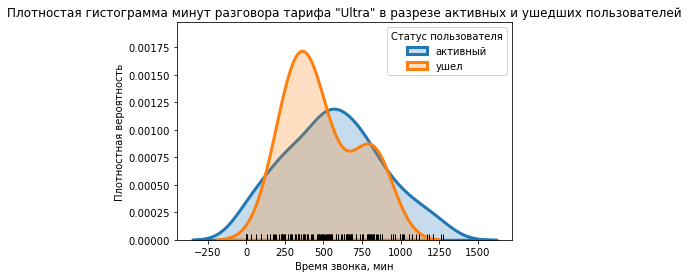

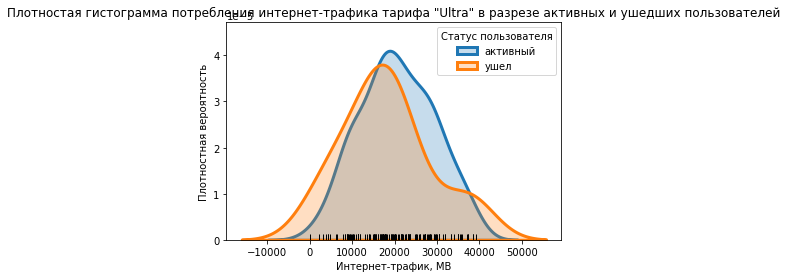

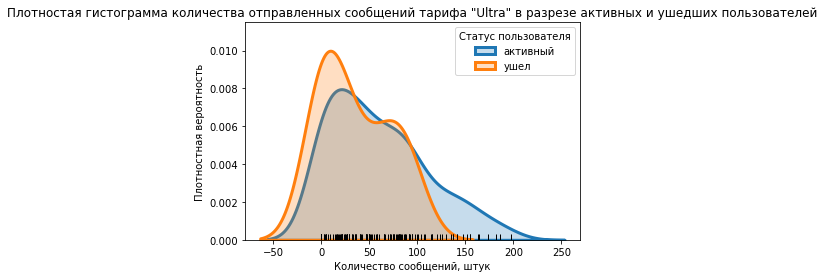

In [53]:
# Построение гистограммы плотностей по среднемесячному количеству минут разговора 
for active in actives:   
        
    # Формирует таблицу
    subset = users_stat[((users_stat['active'] == active) & (users_stat['tariff'] == 'ultra'))]

    # Выводит гистограмму плотностей
    sns.distplot(subset['duration_calls'], hist = False, kde = True, rug=True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 rug_kws={'color': 'black'},
                 label = active)

# Выводит формат для гистограммы
plt.legend(title = 'Статус пользователя')
plt.title('Плотностая гистограмма минут разговора тарифа "Ultra" в разрезе активных и ушедших пользователей')
plt.xlabel('Время звонка, мин')
plt.ylabel('Плотностная вероятность')
plt.show()

# Построение гистограммы плотностей по среднемесячному потреблению интернет-трафика 
for active in actives:   
        
    # Формирует таблицу
    subset = users_stat[((users_stat['active'] == active) & (users_stat['tariff'] == 'ultra'))]

    # Выводит гистограмму плотностей
    sns.distplot(subset['mb_used'], hist = False, kde = True, rug=True,
                 kde_kws = {'shade': True,'linewidth': 3},
                 rug_kws={'color': 'black'},
                 label = active)

    
# Выводит формат для гистограммы
plt.legend(title = 'Статус пользователя')
plt.title('Плотностая гистограмма потребления интернет-трафика тарифа "Ultra" в разрезе активных и ушедших пользователей')
plt.xlabel('Интернет-трафик, MB')
plt.ylabel('Плотностная вероятность')
plt.show()


# Построение гистограммы плотностей по среднемесячному количеству сообщений
for active in actives:   
        
    # Формирует таблицу
    subset = users_stat[((users_stat['active'] == active) & (users_stat['tariff'] == 'ultra'))]

    # Выводит гистограмму плотностей
    sns.distplot(subset['message_count'], hist = False, kde = True, rug=True,
                 kde_kws = {'shade': True,'linewidth': 3},
                 rug_kws={'color': 'black'},
                 label = active)
    
# Выводит формат для гистограммы
plt.legend(title = 'Статус пользователя')
plt.title('Плотностая гистограмма количества отправленных сообщений тарифа "Ultra" в разрезе активных и ушедших пользователей')
plt.xlabel('Количество сообщений, штук')
plt.ylabel('Плотностная вероятность')
plt.show()

Данные также лежат в одном диапазоне, структура распределения почти идентична. 

В связи с полученными данными и небольшой долей ушедших пользователей, убирать их из исследования мы не будем. Они также отражают поведение клиентов в определенном тарифе. Анализ оттока покупателей очень важный аспект, но в рамках данного исследования такой задачи не стоит.

Сформируем итоговую таблицу со всеми данными.

In [54]:
#добавляет данные о клиентах
stat = stat.merge(users[['user_id','age','city','reg_date','reg_date_month','tariff']],
                  on='user_id', how='left')

#добавляет информацию о тарифах
stat = stat.merge(tariffs, left_on='tariff', right_on='tariff_name',how='left')

display(stat.head())
stat.info()

,user_id,month,count_calls,duration_calls,mb_used,message_count,age,city,reg_date,reg_date_month,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,17.0,159.0,2256.0,22.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,6,28.0,172.0,23257.0,60.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,7,41.0,340.0,14016.0,75.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,8,42.0,408.0,14070.0,81.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,9,46.0,466.0,14581.0,57.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   count_calls            3214 non-null   float64       
 3   duration_calls         3214 non-null   float64       
 4   mb_used                3214 non-null   float64       
 5   message_count          3214 non-null   float64       
 6   age                    3214 non-null   int64         
 7   city                   3214 non-null   object        
 8   reg_date               3214 non-null   datetime64[ns]
 9   reg_date_month         3214 non-null   int64         
 10  tariff                 3214 non-null   object        
 11  messages_included      3214 non-null   int64         
 12  mb_per_month_included  3214 non-null   int64         
 13  min

Промежуточные результаты:
- Предположили, что "нулевые" звонки относятся к входящим звонкам, поэтому исключиили их из анализа, чтобы не исказить данные по количеству звонков пользователем в месяц. Нас интересуют исходящие звонки, именно они учитываются в тарифе и именно за сверхтарифные исходящие минуты взимается плата. 
- Предположение, что нулевые значения интернет-трафика связаны с техническими процессами, так как они появляются даже тогда, когда в этот день был использован интернет-трафик. Нулевые значения интернет-трафика не влияют на итоговую сумму использованного интернет-трафика, поэтому данные оставили без изменений.
- В выборке представлены как активные, так и ушедшие клиенты. Хотя средние значения ушедших пользователей ниже средних значений активных пользователей, но распределение данных находится в тех же диапазонах. Такая разница в средних значениях может быть обусловлена небольшой долей ушедших, поэтому данные оставили без изменения. Из анализа исключили только двух пользователей, котрые подключались к тарифу лишь на пару дней и не пользовались пакетом услуг.

### Расчет дополнительных показателей

Добавим помесячную выручку в итоговую таблицу.

In [55]:
def minute_above_tariff(row):
    """Возвращает количество сверх-тарифных минут разговора."""
    duration_calls = row['duration_calls']
    minutes_included = row['minutes_included']
    
    return max(duration_calls - minutes_included, 0)

def gb_above_tariff(row):
    """Возвращает количество использованного сверх-тарифа интернет-трафика."""
    mb_used = row['mb_used']
    mb_per_month_included = row['mb_per_month_included']
    
    return max(np.ceil((mb_used - mb_per_month_included)/1024), 0)
        
def message_above_tariff(row):
    """Возвращает количество сообщений, отправленных сверх-тарифа."""
    message_count = row['message_count']
    messages_included = row['messages_included']
    
    return max((message_count - messages_included),0)
    
#рассчитывает количество дополнительных минут разговора, интерне-трафика и сообщений
stat['up_minute'] = stat.apply(minute_above_tariff, axis=1)
stat['up_gb'] = stat.apply(gb_above_tariff, axis=1)
stat['up_message'] = stat.apply(message_above_tariff, axis=1)

#рассчитывает стоимость дополнительных минут разговора, интерне-трафика и сообщений
stat['income_minute'] = stat['up_minute'] * stat['rub_per_minute']
stat['income_gb'] = stat['up_gb'] * stat['rub_per_gb']
stat['income_message'] = stat['up_message'] * stat['rub_per_message']

#рассчитывает общий доход оператора за месяц
stat['income_total'] = stat['income_minute'] + stat['income_gb'] + stat['income_message'] + stat['rub_monthly_fee']

stat.head()


,user_id,month,count_calls,duration_calls,mb_used,message_count,age,city,reg_date,reg_date_month,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,up_minute,up_gb,up_message,income_minute,income_gb,income_message,income_total
0,1000,5,17.0,159.0,2256.0,22.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
1,1000,6,28.0,172.0,23257.0,60.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
2,1000,7,41.0,340.0,14016.0,75.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
3,1000,8,42.0,408.0,14070.0,81.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
4,1000,9,46.0,466.0,14581.0,57.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.0,0.0,0.0,0.0,1950.0


Данные подготовили, перейдем непосредственно к анализу поведения клиентов.

## Исследование клиенского поведения

### Клиенты - кто они?

Для начала посмотрим общую информацию о клиентах: из каких они городов и какого возраста.

Сгруппируем всех пользователей по городам и рассчитаем, какую долю составляют клиенты каждого города относительно общего количества. Выведем топ-10 городов с наибольшим количеством клиентов.

In [56]:
#формирует сводную таблицу в разрезе городов
city = users_stat.pivot_table(index='city', 
                              aggfunc={'user_id':'count'}).sort_values(by='user_id',ascending=False)

#добавление в сводную таблицу какую долю занимает город в общем количестве клиентов
city['share_of_total'] = ((city['user_id']/city['user_id'].sum()) *100)
city.head(10)

,user_id,share_of_total
city,,
Москва,99,19.879518
Санкт-Петербург,39,7.831325
Новосибирск,16,3.212851
Казань,14,2.811245
Омск,13,2.610442
Уфа,12,2.409639
Набережные Челны,11,2.208835
Краснодар,11,2.208835
Екатеринбург,11,2.208835


Как мы видим из таблицы, основная концентрация клиентов оператора представлена в Москве - почти 20% клиентов, далее идет Санкт-Петербург - почти 8% клиентов, а остальные клиенты небольшими группами распределены по разным городам России. Создадим категорию, где для всех городов, кроме Москвы поставим тип регион и сравним, как отличаются средние показатели.


In [57]:
def region(row):
    #функция на входе принимает ряд из DataFrame, и в зависимости от названия города
    #возвращает 'регион' или 'Москва'
    city = row['city']
    
    if city == 'Москва':
        return 'Москва'
    return 'регион'

#добавляет новый парметр
users_stat['region'] = users_stat.apply(region, axis=1)

users_stat.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_date_month,active,count_calls,duration_calls,mb_used,message_count,month,region
0,1000,52,активный,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,активный,39.5,339.0,14325.5,65.0,8.0,регион
1,1001,41,активный,Москва,Иван,Ежов,2018-11-01,smart,11,активный,46.0,422.0,16252.5,0.0,2.0,Москва
2,1002,59,активный,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,активный,25.0,214.0,17601.0,11.0,7.0,регион
3,1003,23,активный,Москва,Белла,Белякова,2018-08-17,ultra,8,активный,95.0,824.0,11368.0,83.0,5.0,Москва
4,1004,68,активный,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,активный,18.0,132.5,17828.5,154.5,8.0,регион


Параметр добавили, теперь посмотрим на основные показатели.

In [58]:
#формирует сводную таблицу в разрезе городов
region = users_stat.pivot_table(index='region', 
                              aggfunc={'user_id':'count','count_calls':'median',
                                      'duration_calls':'median','mb_used':'median',
                                      'message_count':'median'})

#меняет местами параметры
new_order= ['user_id','count_calls','duration_calls','mb_used', 'message_count']
region = region.reindex(new_order, axis=1)

region

,user_id,count_calls,duration_calls,mb_used,message_count
region,,,,,
Москва,99,54.0,491.0,17220.0,28.5
регион,399,51.0,459.0,17593.0,33.0


Видим, что в Москве клиенты в среднем совершают на 3 звонка в месяц больше, соответственно и тратят больше минут разговора, а вот сообщений отправляют на 5 меньше, чем в регионах. А гигабайты-интернет трафика в среднем тратят одинаково.

Посмотрим на возраст клиентов. Выведим минимальный и максимальный возраст.

In [59]:
users_stat['age'].agg(['min','max'])

min    18
max    75
Name: age, dtype: int64

Сгруппируем клиентов по возрасту в три группы: 18-35 лет, 36-55 лет и свыше 55 лет.

In [60]:
#добавляет категорию по возрасту
users_stat['age_group'] = pd.cut(users_stat['age'],[18,35,55,75],labels=['18-35','36-55','свыше 55'])

#формирует сводную таблицу
age = users_stat.pivot_table(index='age_group',
                       aggfunc = {'user_id':'count'})

#добавляет долю клиентов в возрастной категории относительно общего количества
age['share_of_total'] = ((age['user_id']/age['user_id'].sum()) *100)
age

,user_id,share_of_total
age_group,,
18-35,140,28.455285
36-55,183,37.195122
свыше 55,169,34.349593


Можем сказать, что клиенты оператора равномерно представлены в каждой возрастной группе.
Посмортим на  количество звонков, минут разговора, сообщений и интернет-трафика, использованных в среднем за месяц, в разрезе возрастных категорий.

In [61]:
calls.groupby(['user_id','call_date_month']).sum().head()

id  duration
user_id call_date_month                    
1000    5                18404656       159
        6                33018346       172
        7                34317259       340
        8                34638486       408
        9                46130556       466

In [62]:
users_stat.pivot_table(index='age_group',
                       columns='tariff',
                       aggfunc = {'count_calls':'median',
                                  'duration_calls':'median',
                                  'mb_used':'median',
                                  'message_count':'median'})

count_calls       duration_calls           mb_used           \
tariff          smart ultra          smart   ultra     smart    ultra   
age_group                                                               
18-35           49.75  56.0         445.00  494.50  17565.75  20169.5   
36-55           49.00  63.5         439.50  554.25  16729.00  18876.5   
свыше 55        51.00  63.0         438.75  548.00  16695.50  20174.0   

          message_count         
tariff            smart  ultra  
age_group                       
18-35             27.75  80.25  
36-55             25.00  32.50  
свыше 55          29.00  51.00

В целом, средние показатели по тарифу "Smart" в зависимости от возрастных групп не сильно отличаются, чего нельзя сказать про тариф "Ultra". Видим, что количество минут разговоров у клиентов от 18 до 35 лет при тех же количествах совершенных звонков самое минимальное, а у клиентов двух других возрастных  групп примерно одинаковое. Клиенты от 36 до 55 лет меньше всех потребляют интернет-трафик - примерно 19 ГБ. Также можно выделить, что клиенты от 18 до 35 лет отправляют больше всего сообщений - порядка 80 штук в месяц.

Промежуточные выводы:
- Основная концентрация клиентов оператора представлена в Москве - почти 20% клиентов, далее идет Санкт-Петербург - почти 8% клиентов, а остальные клиенты небольшими группами распределены по разным городам России. Клиенты в Москве и в регионах в среднем используют похоже количество услуг.
- Клиенты оператора равномерно представлены в каждой возрастной группе. Клиенты тарифа "Smart" в среднем потребляют одинаковое количество услуг, не зависимо от возраста. Клиенты тарифа "Ultra" используют пакет услуг по разному:
    - клиенты от 18 до 35 лет больше предпочитают отправлять сообщения (порядка 80 штук в месяц) и использовать интернет (примерно 20ГБ в месяц), а вот при тех же количествах звонков тратят меньше минут разговоров (примерно 495 минут в месяц), чем остальные пользователи.
    - клиеты от 36 до 55 лет больше предпочитают разговоры по телефону (в среднем 554 минут в месяц), чем отправлять сообщения - примерно 33 сообщения в месяц - самый низкий показатель среди клиентов тарифа "Ultra". Они также используют меньше интернет-трафика в сравнении с остальными пользователями - почти 19ГБ. 
    - клиенты свыше 55 лет много разговаривают (548 минут в среднем), активно используют интернет (20ГБ в месяц) и не против отправить сообщение (51 сообщение в месяц)

### Анализ основных показателей в разрезе тарифов

Начнем анализ с количества сделанных звонков пользователями. Сгруппируем данные объединенной таблицы **stat** и построим гистограмму распределения среднего количества звонков в разрезе тарифов.

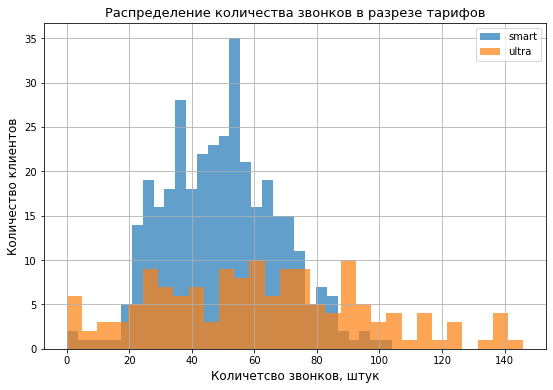

In [63]:
#группирует данные по пользователям и тарифу
stat_group_users = stat.groupby(['tariff','user_id']).median().reset_index()

#выводит гистограмму распределения
def plot_hist(column,title,xlabel_name):
    ax = stat_group_users.query('tariff == "smart"').plot(
        kind='hist',
        y=column,
        figsize=(9,6),
        bins=30,
        linewidth=5,
        alpha=0.7,
        label='smart'
    )
    stat_group_users.query('tariff == "ultra"').plot(
        kind='hist',
        y=column,
        figsize=(9,6),
        bins=30,
        ax=ax,
        linewidth=5,
        alpha=0.7,
        label='ultra',
    )

    #задает формат
    plt.grid(True)
    plt.title('Распределение '+title+' в разрезе тарифов', fontsize=13)
    plt.xlabel(xlabel_name, fontsize=12)
    plt.ylabel('Количество клиентов', fontsize=12)
    plt.show()


plot_hist('count_calls','количества звонков','Количетсво звонков, штук')

Можем сказать, что распределение среднего количества звонков клиентами тарифа "Smart" более плотно сконцентрировано, чем тарифа "Ultra". Построим диаграмму размаха.

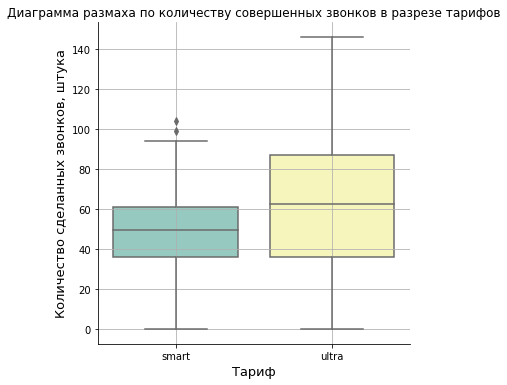

In [64]:
def catplot_box(column,title,ylabel_name):
    
    #выводит диаграмму размаха
    sns.catplot(x="tariff", y=column, kind="box", data=stat_group_users, orient='v',
                palette="Set3")

    #задает форматирование
    plt.title('Диаграмма размаха '+title+' в разрезе тарифов')
    plt.xlabel('Тариф', fontsize=13)
    plt.ylabel(ylabel_name, fontsize=13)
    plt.grid(True)
    plt.show()
    
catplot_box('count_calls','по количеству совершенных звонков','Количество сделанных звонков, штука')

Исходя их диаграммы размахов можем отметить следующее:
- Клиенты тарифа "Smart" в среднем совершают меньшее количетсво звонков, чем клиенты тарифа "Ultra".
- Распределение количество звонков клиентами тарифа "Ultra" шире, чем у клиентов тарифа  "Smart".
- Присутствуют два значения, выходящие за рамки "усов" тарифа "Smart", но их значения находятся достаточно близко, поэтому исключать из анализа их не будем.

Рассчитаем для каждого тарифа медиану, дисперсию и стандартное отклонение.

In [65]:
stat_group_users.pivot_table(index='tariff', aggfunc={'count_calls': [np.median, np.var, np.std]})

count_calls                        
            median        std          var
tariff                                    
smart        49.75  18.046667   325.682202
ultra        62.50  34.379109  1181.923148

Клиенты тарифа "Ultra" в среднем совершают большее количество звонков (примерно 63 звонка), чем клиенты тарифа "Smart" (почти 50 звонков). Дисперсия и стандартное отклонение более дорогого тарифа также выше.

Теперь посмотрим на распределение минут разговора.

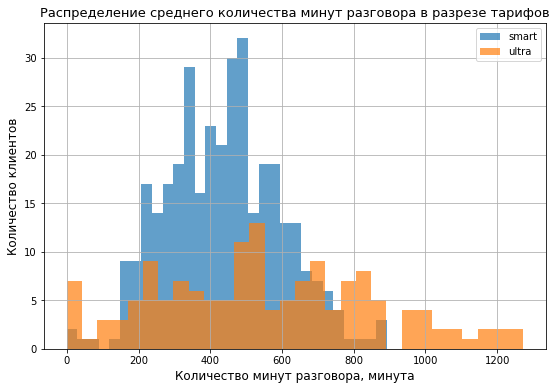

In [66]:
#выводит гистограмму распределения
plot_hist('duration_calls','среднего количества минут разговора','Количество минут разговора, минута')


Гистограмма распреденения по минутам разговора очень похожа на гистограмму распределения по количеству звонков. Можем сказать, что распределение среднего количества минут разговора клиентами тарифа "Smart" более плотно сконцентрировано, чем тарифа "Ultra". Построим диаграмму размаха.

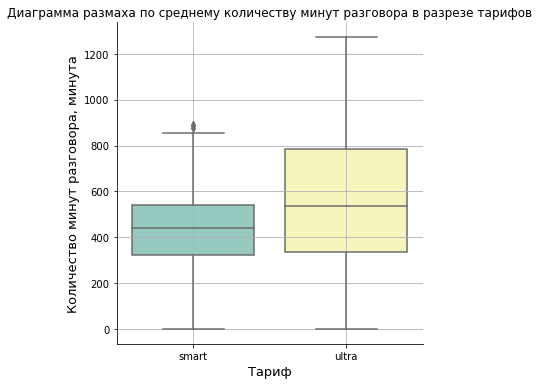

In [67]:
catplot_box('duration_calls','по среднему количеству минут разговора','Количество минут разговора, минута')


Исходя их диаграммы размахов можем отметить следующее:
- Клиенты тарифа "Smart" в среднем разговаривают меньшее, чем клиенты тарифа "Ultra".
- Распределение количества минут разговора клиентами тарифа "Ultra" шире, чем у клиентов тарифа  "Smart".
- Присутствуют несколько значений, выходящие за рамки "усов" тарифа "Smart", но они находятся достаточно близко, поэтому исключать их из анализа также не будем.
- Количество минут разговора клиентами тарифа "Ultra" находится в рамках тарифного плана, а вот половина клиентов тарифа "Smart" выходят за пределы 500 минут разговора, включенного в тариф.

Рассчитаем для каждого тарифа медиану, дисперсию и стандартное отклонение.

In [68]:
stat_group_users.pivot_table(index='tariff', aggfunc={'duration_calls': [np.median, np.var, np.std]})

duration_calls                          
               median         std           var
tariff                                         
smart          439.75  160.266622  25685.390127
ultra          535.25  303.793641  92290.576519

Клиенты тарифа "Smart" в среднем за месяц разговаривают около 440 минут, что находится в рамках тарифного плана. Клиенты тарифа "Ultra" в среднем разговаривают 535 минут в месяц, что больше, чем клиенты тарифа "Smart", и гораздо меньше минут разговоров, включенного в тарифный план - 3000 минут.
Дисперсия и стандартное отклонение тарифа "Ultra" выше, чем у тарифа "Smart".

Проанализируем среднее количества используемого интернет-трафика клиентами обоих тарифов.

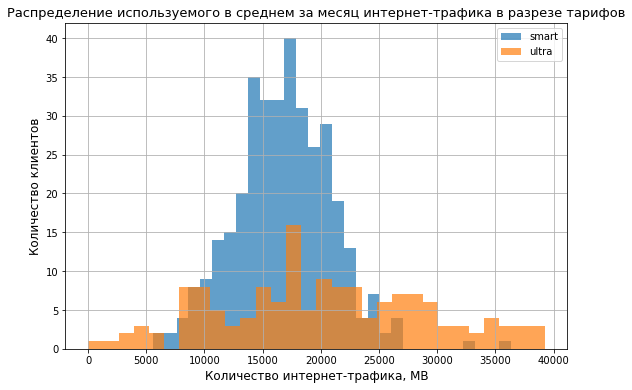

In [69]:
#выводит гистограмму распределения
plot_hist('mb_used','используемого в среднем за месяц интернет-трафика','Количество интернет-трафика, MB')


Распределение среднего количества интернет-трафика клиентами тарифа "Smart" более плотно сконцентрировано, чем тарифа "Ultra". Построим диаграмму размаха.

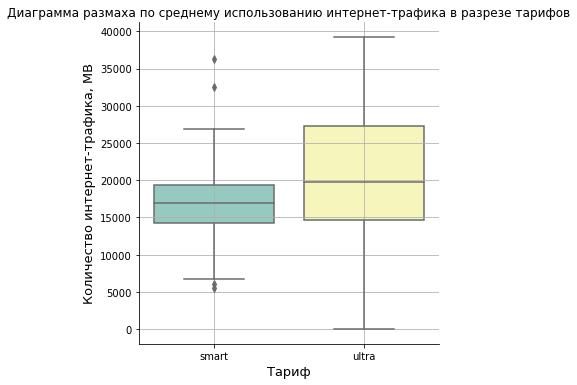

In [70]:
catplot_box('mb_used','по среднему использованию интернет-трафика','Количество интернет-трафика, MB')


Исходя их диаграммы размахов можем отметить следующее:
- Клиенты тарифа "Smart" в среднем используют меньшее количество интернет-трафика, чем клиенты тарифа "Ultra". 
- Почти 75% клиентов тарифа "Smart" выходят за пределы 15ГБ, включенных в тарифный план.
- Если по минутам разговора все клиенты тарифа "Ultra" укладывались в тарифный пакет минут,то по количеству интернет-трафика меньше четверти клиентов выходят за пределы тарифного пакета.
- Присутствуют значения ниже и выше "усов" тарифа "Smart". Если нижние выбросы находятся достаточно близко, то верхние - достаточно далеко. Посмотрим, что это за клиенты.

In [71]:
users_more =  users_stat.query('tariff == "smart" and mb_used > 30000')['user_id']

users_stat.query('tariff == "smart" and mb_used > 30000')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_date_month,active,count_calls,duration_calls,mb_used,message_count,month,region,age_group
261,1261,46,активный,Казань,Мадина,Пантелеева,2018-10-30,smart,10,активный,82.0,738.0,32542.0,22.0,3.0,регион,36-55
486,1486,35,активный,Нижний Новгород,Матвей,Моргунов,2018-10-31,smart,10,активный,84.0,764.0,36319.0,83.0,3.0,регион,18-35


Таких клиентов двое, оба подключилист к тарифу в конце октября. Исключим их из дальнейшего анализа.

Рассчитаем для каждого тарифа медиану, дисперсию и стандартное отклонение.

In [72]:
stat_group_users.pivot_table(index='tariff', aggfunc={'message_count': [np.median, np.var, np.std]})

message_count                        
              median        std          var
tariff                                      
smart           28.5  28.010653   784.596662
ultra           47.5  49.236809  2424.263318

Клиенты тарифа "Smart" в среднем за месяц используют около 17ГБ интернет-трафика, что, как отметили ранее, находится за рамками тарифного плана. Клиенты тарифа "Ultra" в среднем используют около 20ГБ интернет-трафика. Дисперсия и стандартное отклонение тарифа "Ultra" выше, чем у тарифа "Smart".

Проанализируем среднее количества отправленных сообщений клиентами обоих тарифов.

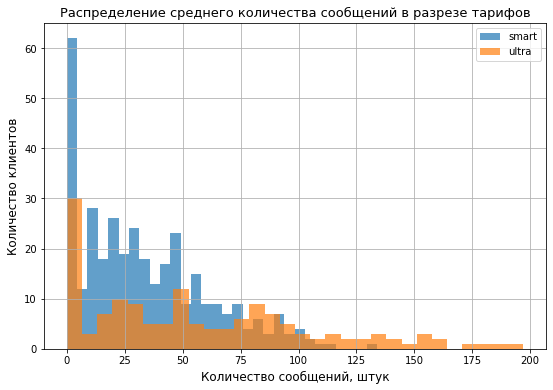

In [73]:
#выводит гистограмму распределения
plot_hist('message_count','среднего количества сообщений','Количество сообщений, штук')


Для обоих тарифоф наблюдаем пик в районе 0, что говорит о том, что есть клиенты, не использующие сообщения в принципе. Оба расспределения ассиметричны и скошены вправо.

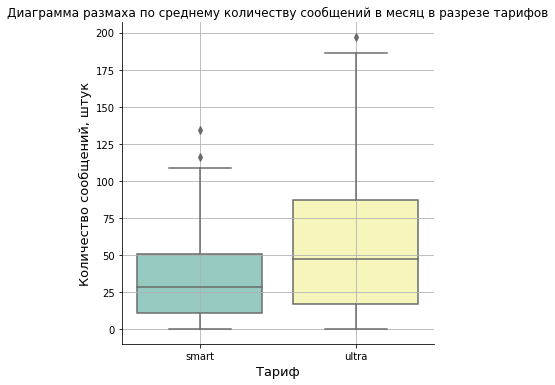

In [74]:
catplot_box('message_count','по среднему количеству сообщений в месяц','Количество сообщений, штук')


Исходя их диаграммы размахов можем отметить следующее:
- Клиенты тарифа "Smart" в среднем отправляют сообщений меньшее, чем клиенты тарифа "Ultra".
- Примерно 75% клиентов тарифа "Smart" не выходят за пределы 50 сообщений, включенных в тарифный план.
- А вот клиенты тарифа "Ultra" отправляют в среднем максимально около 200 сообщений, что далеко от границ тарифа в 1000 сообщений.
- Распределение количества отправленных сообщений клиентами тарифа "Ultra" шире, чем у клиентов тарифа  "Smart".
- Присутствуют несколько значений, выходящие за рамки "усов" как тарифа "Smart", так и тарифа "Ultra". Уберем из анализа только выброс по тарифу "Smart", лежащий за пределами в 125 сообщений.

Добавим в список **user_id** на исключение из анализа данный выброс по собщениям.

In [75]:
users_more =  users_more.append(users_stat.query('tariff == "smart" and message_count > 125')['user_id'])
print(users_more)

261    1261
486    1486
324    1324
Name: user_id, dtype: int64


Рассчитаем для каждого тарифа медиану, дисперсию и стандартное отклонение.

In [76]:
stat_group_users.pivot_table(index='tariff', aggfunc={'message_count': [np.median, np.var, np.std]})

message_count                        
              median        std          var
tariff                                      
smart           28.5  28.010653   784.596662
ultra           47.5  49.236809  2424.263318

Клиенты тарифа "Smart" в среднем за месяц отправляют около 29 сообщений, что находится в рамках тарифного плана. Клиенты тарифа "Ultra" в среднем отправляют около 48 сообщений, что также в рамках тарифного плана.
Дисперсия и стандартное отклонение тарифа "Ultra" выше, чем у тарифа "Smart".

Промежуточные выводы:
1. Клиенты тарифа "Ultra" чаще звонят и тратят больше минут разговора - примерно 63 звонка и в среднем 535 минут разговора за месяц, чем клиенты тарифа "Smart" - почти 50 звонков и 440 минут разговора за месяц. Клиенты тарифа "Ultra" испольуют свой пакет минут в среднем лишь на 18%, когда клиенты тарифа "Smart" в среднем почти на 90%, но очень часто выходят за рамки бесплатного пакета минут. Дисперсия и стандартное отклонение тарифа "Ultra" выше, чем у тарифа "Smart".


2. Клиенты тарифа "Ultra" больше проводят времени в интернете, в среднем используя 20ГБ интернет, чем клиенты тарифа "Smart", которые в среднем за месяц используют 17ГБ. Бесплатного пакета гигабайт не хватает ни клиентам тарифа "Smart", ни клиентам тарифа "Ultra". Если в более дорогом тарифе примерно четверть клиентов выходят за пределы бесплатного пакета гигибайт, то в более дешевом тарифе - порядка 75% клиентов. Дисперсия и стандартное отклонение тарифа "Ultra" выше, чем у тарифа "Smart".


3. Клиенты тарифа "Ultra" также чаще отправляют сообщения - в среднем 48 сообщений в месяц, чем клиенты тарифа "Smart", которые в среднем отправляют 29 сообщений в месяц. Примерно четверть клиентов тарифа "Smart" выходя за пределы бесплатного пакета сообщений, а вот клиенты тарифа "Ultra" используют бесплатный пакет сообщений только максимум на 20%. Для каждого тарифа характерно ассиметричность и скошенность распределения вправо. Также в каждом тарифе есть клиенты, вообще не использующие пакет сообщений.Дисперсия и стандартное отклонение тарифа "Ultra" выше, чем у тарифа "Smart".

### Анализ дохода от клиентов в разрезе тарифов

Для начала исключим из наших данных выбросы, найденые в предыдущей главе.

In [77]:
stat_net = stat.query('user_id not in @users_more')
print('Количество пользователей в исходной таблице:',len(stat.groupby('user_id')))
print('Количество пользователей в новой таблице:',len(stat_net.groupby('user_id')))

Количество пользователей в исходной таблице: 498
Количество пользователей в новой таблице: 495


Посмотрим на общий доход, а также доход от минут разговора, сообщений и интернет-трафика, в разрезе тарифов.

In [78]:
#создает таблицу, сгруппированную по тарифам
income_group = stat_net.pivot_table(index='tariff',
                    values=['rub_monthly_fee','income_minute','income_gb','income_message','income_total'],
                    aggfunc='sum')
                    #margins = True, margins_name='Total')

#создает таблицу с количеством пользователей
income_users = stat_net.pivot_table(index=['tariff','user_id'],values='city',
                                    aggfunc='count').reset_index().pivot_table(
    index='tariff',values='user_id',aggfunc='count')

#добавляет в таблицут 'income_group' количество пользователей
income_group = income_group.merge(income_users, on='tariff', how='left')

#добавляет в сводную таблицу какую долю занимает каждый показатель в общей его сумме
for income in ['rub_monthly_fee','income_minute','income_gb','income_message','income_total']:
    income_group['share_'+income] = ((income_group[income]/income_group[income].sum()) *100)

#меняет местами параметры
new_order= ['user_id','rub_monthly_fee','share_rub_monthly_fee','income_minute','share_income_minute',
            'income_gb','share_income_gb','income_message','share_income_message',
            'income_total','share_income_total']
income_group = income_group.reindex(new_order, axis=1)
income_group

,user_id,rub_monthly_fee,share_rub_monthly_fee,income_minute,share_income_minute,income_gb,share_income_gb,income_message,share_income_message,income_total,share_income_total
tariff,,,,,,,,,,,
smart,347,1218250,38.810131,268668.0,100.0,1315800.0,91.690185,36810.0,100.0,2839528.0,58.192678
ultra,148,1920750,61.189869,0.0,0.0,119250.0,8.309815,0.0,0.0,2040000.0,41.807322


Видим, что тариф "Smart" приносит оператору 58% от общей выручки, а "Ultra" - почти 42%. Клиентов более дешевого тарифа больше более чем в 2 раза.

Рассмотрим каждый источник дохода отдельно:
- тариф "Ultra" приносить 61% выручки от абонентской выручки, а тариф "Smart" почти 39%
- доход за дополнительные минуты разговора и сообщения приносит только тариф "Smart"
- почти 92% дохода от дополнительных гигабайтов интернет-трафика приносит тариф "Smart", а "Ultra" только 8%.

Посмотрим, какую долю каждый источник дохода занимает в общей сумме дохода по тарифу, а также в общем доходе компании.
Для начала сформируем таблицу для построения круговой диаграммы.

In [79]:
#создает таблицу
for_pie = income_group[['rub_monthly_fee','income_minute','income_gb','income_message']].T

#считает общий доход компании
for_pie['total'] = for_pie['smart'] + for_pie['ultra']
for_pie

tariff,smart,ultra,total
rub_monthly_fee,1218250.0,1920750.0,3139000.0
income_minute,268668.0,0.0,268668.0
income_gb,1315800.0,119250.0,1435050.0
income_message,36810.0,0.0,36810.0


Посмотрим на круговую диаграмму общего дохода оператора.

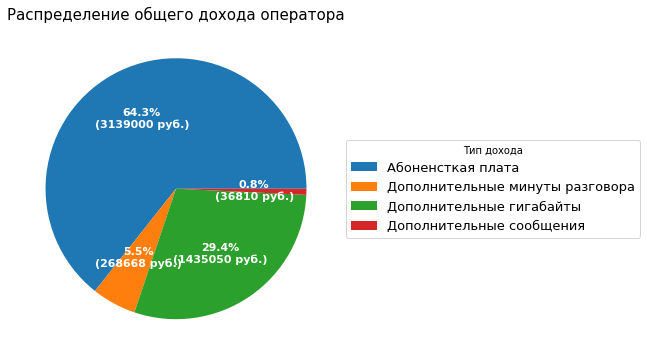

In [80]:
#создает функцию, которая выводит круговую диаграмму
def plt_pie(data, type_income, label):
    #на входе принимает данные, источник дохода и подпись данных
    #выводи круговые диаграммы с заданным параметром
    
    fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(aspect="equal"))

    def func(pct, allvals):
        absolute = int(round(pct/100.*np.sum(allvals)))
        return "{:.1f}%\n({:.0f} руб.)".format(pct, absolute)

    wedges, texts, autotexts  = ax.pie(data, autopct=lambda pct: func(pct, data),
                                      textprops=dict(color="w"))

    ax.legend(wedges, label,
              title="Тип дохода",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1), 
              prop={'size':13})

    plt.setp(autotexts, size=11, weight="bold")

    if type_income == 'smart':
        ax.set_title('Распределение дохода по тарифу "Smart"', size=15)
    elif type_income == 'ultra':
        ax.set_title('Распределение дохода по тарифу "Ultra"', size=15)
    else:
        ax.set_title('Распределение общего дохода оператора', size=15)
        
    plt.show()


#выводит круговую диаграмму общего дохода оператора
plt_pie(for_pie['total'],'total',
        ['Абоненсткая плата','Дополнительные минуты разговора','Дополнительные гигабайты',
         'Дополнительные сообщения'])



Видим, что в общей выручке компании 64,3% занимает доход от абонентской платы, затем 29,4% приносят дополнительные гигабайты интернет-трафика. Дополнительные минуты разговора и сообщений суммарно занимают чуть больше 6%.

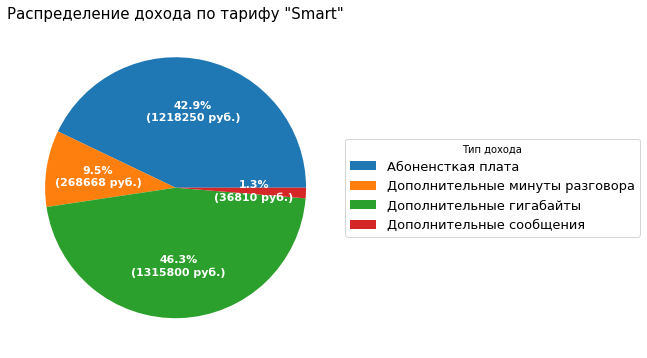

In [81]:
#выводит круговую диаграмму для тарифа "Smart"
plt_pie(for_pie['smart'],'smart',
        ['Абоненсткая плата','Дополнительные минуты разговора','Дополнительные гигабайты',
         'Дополнительные сообщения']
)


А вот структура выручки по тарифу "Smart" выглядит иначе, примерно равный доход приносят абонентская плата и дополнительные гигабайты интернет-трафика.

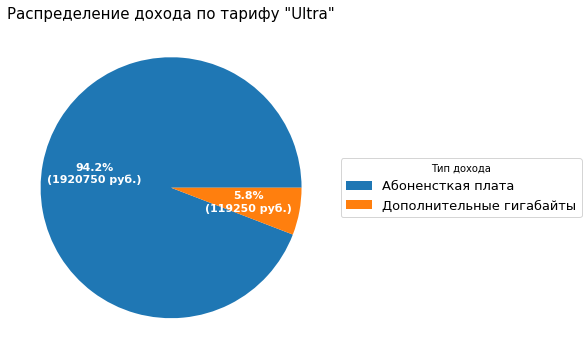

In [82]:
#выводит круговую диаграмму для тарифа "Ultra"
plt_pie(for_pie.query('ultra != 0')['ultra'],'ultra',['Абоненсткая плата','Дополнительные гигабайты'])

Можем сказать, что тариф "Ultra" приносит выручку компании за счет абонентской платы, доля выручки от дополнительных гигабайт интернет-трафика составляет всего 5,8%.

Посмотрим доход по основным показателям в разрезе тарифов в среднем за месяц на одного пользователя, а так же среднее количество минут разговора, гигабайт интернет-трафика и сообщений, которые клиенты используют сверх-тарифа.

In [83]:
#создает таблицу
income_group_per_users=stat_group_users.query('user_id not in @users_more').pivot_table(
    index='tariff', 
    values=['up_minute','up_gb','up_message','rub_monthly_fee','income_minute','income_gb','income_message'],
    aggfunc = 'mean'
)

#добавляет итоговый столбец со средним общим доходом
income_group_per_users['income_total'] = (income_group_per_users['income_minute'] + 
                                          income_group_per_users['income_gb'] + 
                                          income_group_per_users['income_message'] + 
                                          income_group_per_users['rub_monthly_fee'])


#меняет местами параметры
new_order= ['up_minute','up_gb','up_message','rub_monthly_fee','income_minute','income_gb','income_message','income_total']
income_group_per_users = income_group_per_users.reindex(new_order, axis=1)

income_group_per_users

,up_minute,up_gb,up_message,rub_monthly_fee,income_minute,income_gb,income_message,income_total
tariff,,,,,,,,
smart,39.564841,2.804035,5.694524,550.0,118.694524,560.806916,17.083573,1246.585014
ultra,0.000000,0.746622,0.000000,1950.0,0.000000,111.993243,0.000000,2061.993243


Клиенты тарифа "Smart" в среднем в месяц дополнительно используют порядка 40 минут разговора, 3 ГБ интернет-трафика и  6 сообщений. Они в среднем в месяц платят за услуги оператора 1247 руб., которая включает 550 руб. абонентской платы и 697 руб. за дополнительные услуги, в которых порядка 80% занимают  дополнительные гигабайты интернет-трафика.

Клиенты тарифа "Ultra" в среднем в месяц дополнительно используют 1 гигабайт интернет-трафика. Итоговая сумма оплаты услуг оператора лишь немногим выше суммы абонентской платы - на 112 руб.

Посмотрим, отличается ли выручка с пользователя в Москве и регионах.

In [84]:
def region(row):
    #функция на входе принимает ряд из DataFrame, и в зависимости от названия города
    #возвращает 'регион' или 'Москва'
    city = row['city']
    
    if city == 'Москва':
        return 'Москва'
    return 'регион'
    
#добавляет параметр 'region' в таблицу 'stat_net'
stat_net['region'] = stat_net.apply(region, axis=1)
stat_net.head()

,user_id,month,count_calls,duration_calls,mb_used,message_count,age,city,reg_date,reg_date_month,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,up_minute,up_gb,up_message,income_minute,income_gb,income_message,income_total,region
0,1000,5,17.0,159.0,2256.0,22.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,регион
1,1000,6,28.0,172.0,23257.0,60.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,регион
2,1000,7,41.0,340.0,14016.0,75.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,регион
3,1000,8,42.0,408.0,14070.0,81.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,регион
4,1000,9,46.0,466.0,14581.0,57.0,52,Краснодар,2018-05-25,5,ultra,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,регион


Выведем среднюю выручку с одного пользователя.

In [85]:
#создает таблицу
income_group_region = stat_net.groupby(['region','user_id']).median().reset_index().pivot_table(
    index='region', 
    values=['up_minute','up_gb','up_message','rub_monthly_fee','income_minute','income_gb','income_message'],
    aggfunc = 'mean'
)

#добавляет итоговый столбец со средним общим доходом
income_group_region['income_total'] = (income_group_region['income_minute'] + 
                                       income_group_region['income_gb'] +
                                       income_group_region['income_message'] +
                                       income_group_region['rub_monthly_fee'])


#меняет местами параметры
new_order= ['up_minute','up_gb','up_message','rub_monthly_fee','income_minute','income_gb','income_message','income_total']
income_group_region = income_group_region.reindex(new_order, axis=1)

income_group_region

,up_minute,up_gb,up_message,rub_monthly_fee,income_minute,income_gb,income_message,income_total
region,,,,,,,,
Москва,27.510101,1.797980,3.287879,1002.525253,82.530303,356.060606,9.863636,1450.979798
регион,27.791667,2.286616,4.167929,960.101010,83.375000,444.255051,12.503788,1500.234848


В Москве средняя выручка с абонентской платы выше, чем в регионах, а вот по остальным источникам дохода и в общем - ниже, чем в регионах.

Промежуточные выводы:
- Основной источник дохода компании - абонентская плата (64,3% в общей выручке), дополнительные гигабайты интернет-трафика приносят 29,4% выручки, а дополнительные минуты разговора и сообщений суммарно приносят чуть больше 6%.

- Тариф "Smart" оказывает больший вклад в общую выручку компании и приносит 58% от общей выручки, а тариф "Ultra" - почти 42%. Если их рассматривать в разрезе источников дохода, то:
    - тариф "Ultra" приносить 61% выручки от абонентской выручки, а тариф "Smart" почти 39%
    - доход за дополнительные минуты разговора и сообщения приносит только тариф "Smart"
    - почти 92% дохода от дополнительных гигабайтов интернет-трафика приносит тариф "Smart", а "Ultra" только 8%.

- При этом структура дохода внутри тарифа "Smart" выглядит следующим образом: примерно равный доход приносят абонентская плата и дополнительные гигабайты интернет-трафика, а дополнительные минуты разговора и сообщения только порядка 10%.

- Тариф "Ultra" приносит выручку компании за счет абонентской платы, доля выручки от дополнительных гигабайт интернет-трафика составляет всего 5,8%.

- Если рассматривать доход с одного пользователя в разрезе тарифов, то тариф "Ultra" выгоднее. Он приносит с одного клиента порядка 2061 руб. в месяц, когда тариф "Smart" - 1247 руб. Но так как клиентов более дешевого тарифа больше более чем в 2 раза, то тариф "Smart" приносит больше выручки компании за счет объемов.

- Что же касается выручки с одного клиента в Москве и в регионах, то она не сильно отличается. В Москве она составялет 1451 руб., а в регионах - 1500 руб.

## Проверка гипотез

Исходя из нашего исследования, основанном на выборке из 500 пользователей, мы выдвинули две гипотезы:
1. Средняя выручка с одного клиента тарифов "Smart" и "Ultra" различается
2. Средняя выручка с одного клиента из Москвы отличается от средней выручки с одного клиента из региона

Проверим их. Критический уровень статистической значимости примем 5%.

### Проверка гипотеры о различии средней выручки, полученной с одного клиента тарифов "Smart" и "Ultra"

Сформируем Н0 и Н1 гиппотезы.

Гиппотеза Н0 — средняя выручка с одного клиента тарифа «Smart» равна средней выручке с одного клиента тарифа «Ultra».

Гиппотеза Н1 — средняя выручка с одного клиента тарифов «Smart» и «Ultra» различаются.

Так как выборки у нас независимые, воспользуемся методом `ttest_ind` из модуля `scipy.stats`. Кроме того, в нашем анализе дисперсии распределения количества минут разговора, сообщений и интернет-трафика значительно отличались в разрезе тарифов, поэтому зададим значение параметр `equal_var = False`, указывающее на различие дисперсий генеральных совокупностей.

In [86]:
#Формирует массив общих доходов по тарифу "Smart"
income_smart = stat_net.query('tariff == "smart"')['income_total']

#Формирует массив общих доходов по тарифу "Ultra"
income_ultra = stat_net.query('tariff == "ultra"')['income_total']

#Задает критический уровень статистической значимости
alpha = 0.05 

#проверяет гипотезу
results = st.ttest_ind(income_smart, income_ultra, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2170354279144476e-261
Отвергаем нулевую гипотезу


Нулевая гипотеза не подтвердилась. Таким образом у нас есть все основания полагать, что средняя выручка с одного клиента тарифов "Smart" и "Ultra" различается. 

### Проверка гипотеры о различии средней выручки с одного клиента в Москве и в регионах

Сформируем Н0 и Н1 гиппотезы.

Гиппотеза Н0 — средняя выручка с одного клиента в Москве равна средней выручке с одного клиента в регионах.

Гиппотеза Н1 — средняя выручка с одного клиента в Москве и регионах различаются.

Так как выборки у нас независимые, воспользуемся методом `ttest_ind` из модуля `scipy.stats`. В ходе анализа основные показатели в Москве и в регионах были близки, поэтому примем, что дисперсии двух совокупностей примерно равные.

In [87]:
#Формирует массив общих доходов по тарифу "Smart"
income_moscow = stat_net.query('region == "Москва"')['income_total']

#Формирует массив общих доходов по тарифу "Ultra"
income_region = stat_net.query('region == "регион"')['income_total']

#Задает критический уровень статистической значимости
alpha = 0.05 

#проверяет гипотезу
results = st.ttest_ind(income_moscow, income_region)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.3621435724628279
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не получилось. Если и есть разница между средними выручками с одного клиента в Москве и в регионах, то она не существенная.

## Вывод

**Что сделали:**
1. Снизили потребление памяти, изменили тип данных
    1. Cнизили потребление памяти таблице `calls` с 28.6 до 5.4 MB, изменив тип данных параметров:
        - id на int32,
        - duration на float32,
        - user_id на int16,
        - call_date перевели в формат даты.
    2. Cнизили потребление памяти таблице `internet` с 22.2 до 5.1 MB, изменив тип данных параметров:
        - id на int32,
        - mb_used на float32,
        - user_id на int16,
        - session_date переведли в формат даты.
    3. Cнизили потребление памяти таблице `messages` с 16.4 до 2.3 MB, изменив тип данных параметров:
        - id на int32,
        - user_id на int16,
        - message_date перевели в формат даты.
    4. Таблицу `tariffs` оставили без изменений из-за потребления небольшого количества памяти.
    5. В таблице `users` параметр reg_date перевели в формат даты, пропуски в параметре churn_date заменили на "активные".


2. Проанализировали исходные данные
    - Предположили, что "нулевые" звонки относятся к входящим звонкам, поэтому исключиили их из анализа, чтобы не исказить данные по количеству звонков пользователем в месяц. Нас интересуют исходящие звонки, именно они учитываются в тарифе и именно за сверхтарифные исходящие минуты взимается плата. 
    - Предположение, что нулевые значения интернет-трафика связаны с техническими процессами, так как они появляются даже тогда, когда в этот день был использован интернет-трафик. Нулевые значения интернет-трафика не влияют на итоговую сумму использованного интернет-трафика, поэтому данные оставили без изменений.
    - В выборке представлены как активные, так и ушедшие клиенты. Хотя средние значения ушедших пользователей ниже средних значений активных пользователей, но распределение данных находится в тех же диапазонах. Такая разница в средних значениях может быть обусловлена небольшой долей ушедших, поэтому данные оставили без изменения.


3. Скорректировали данные по минутам разговора и использованному интернет-трафику, округлив их вверх,  на основании в соответствие с регламентом компании.


4. Рассчитали дополнительные параметры: 
    - общее количество сделанных звонков и израсходованных минут разговора по месяцам,
    - количество израсходованных минут разговора сверх тарифного пакета по месяцам,
    - общее количество отправленных сообщений по месяцам,
    - количество отправленных сообщений сверх тарифного пакета по месяцам,
    - общий объем израсходованного интернет-трафика по месяцам,
    - объем израсходованного интернет-трафика сверх тарифного пакета по месяцам,
    - помесячную выручку с каждого пользователя: общую и в разрезе источников дохода (минут разговора, сообщений и интернет-трафика).
 
5. Из анализа исключили четырех пользователей: 
    - два клиента подключились к тарифу лишь на пару дней и не воспользовались пакетом услуг, 
    - основании распределения использования интернет-трафика выявили выбросы и исключили двух клиентов.

**Выводы на основании выборки из 500 клиентов оператора:**

1. Основная концентрация клиентов оператора представлена в Москве - почти 20% клиентов, далее идет Санкт-Петербург - почти 8% клиентов, а остальные клиенты небольшими группами распределены по разным городам России. Клиенты в Москве и в регионах в среднем используют похоже количество услуг.


2. **Клиенты оператора равномерно представлены в каждой возрастной группе.** Клиенты тарифа "Smart" в среднем потребляют одинаковое количество услуг, не зависимо от возраста. Клиенты тарифа "Ultra" используют пакет услуг по разному:
    - клиенты от 18 до 35 лет больше предпочитают отправлять сообщения (порядка 80 штук в месяц) и использовать интернет (примерно 20ГБ в месяц), а вот при тех же количествах звонков тратят меньше минут разговоров (примерно 495 минут в месяц), чем остальные пользователи.
    - клиеты от 36 до 55 лет больше предпочитают разговоры по телефону (в среднем 554 минут в месяц), чем отправлять сообщения - примерно 33 сообщения в месяц - самый низкий показатель среди клиентов тарифа "Ultra". Они также используют меньше интернет-трафика в сравнении с остальными пользователями - почти 19ГБ.
    - клиенты свыше 55 лет много разговаривают (548 минут в среднем), активно используют интернет (20ГБ в месяц) и не против отправить сообщение (51 сообщение в месяц)


**3. Использование пакетов услуг клиентами тарифов "Smart" и "Ultra" различается:**


    1. Клиенты тарифа "Ultra" чаще звонят и тратят больше минут разговора - примерно 63 звонка и в среднем 535 минут разговора за месяц, чем клиенты тарифа "Smart" - почти 50 звонков и 440 минут разговора за месяц. Клиенты тарифа "Ultra" испольуют свой пакет минут в среднем лишь на 18%, когда клиенты тарифа "Smart" в среднем почти на 90%, но очень часто выходят за рамки бесплатного пакета минут. Дисперсия и стандартное отклонение тарифа "Ultra" выше, чем у тарифа "Smart".

    2. Клиенты тарифа "Ultra" больше проводят времени в интернете, в среднем используя 20ГБ интернет, чем клиенты тарифа "Smart", которые в среднем за месяц используют 17ГБ. Бесплатного пакета гигабайт не хватает ни клиентам тарифа "Smart", ни клиентам тарифа "Ultra". Если в более дорогом тарифе примерно четверть клиентов выходят за пределы бесплатного пакета гигибайт, то в более дешевом тарифе - порядка 75% клиентов. Дисперсия и стандартное отклонение тарифа "Ultra" выше, чем у тарифа "Smart".


    3. Клиенты тарифа "Ultra" также чаще отправляют сообщения - в среднем 48 сообщений в месяц, чем клиенты тарифа "Smart", которые в среднем отправляют 29 сообщений в месяц. Примерно четверть клиентов тарифа "Smart" выходя за пределы бесплатного пакета сообщений, а вот клиенты тарифа "Ultra" используют бесплатный пакет сообщений только максимум на 20%. Для каждого тарифа характерно ассиметричность и скошенность распределения вправо. Также в каждом тарифе есть клиенты, вообще не использующие пакет сообщений.Дисперсия и стандартное отклонение тарифа "Ultra" выше, чем у тарифа "Smart".

**4. Зависимость дохода оператора от тарифа и источника дохода:**

    1. Основной источник дохода компании - абонентская плата (64,3% в общей выручке), дополнительные гигабайты интернет-трафика приносят 29,4% выручки, а дополнительные минуты разговора и сообщений суммарно приносят чуть больше 6%.

    2. Тариф "Smart" оказывает больший вклад в общую выручку компании и приносит 58% от общей выручки, а тариф "Ultra" - почти 42%. Если их рассматривать в разрезе источников дохода, то:
        - тариф "Ultra" приносить 61% выручки от абонентской выручки, а тариф "Smart" почти 39%
        - доход за дополнительные минуты разговора и сообщения приносит только тариф "Smart"
        - почти 92% дохода от дополнительных гигабайтов интернет-трафика приносит тариф "Smart", а "Ultra" только 8%.

     3. При этом структура дохода внутри тарифа "Smart" выглядит следующим образом: примерно равный доход приносят абонентская плата и дополнительные гигабайты интернет-трафика, а дополнительные минуты разговора и сообщения только порядка 10%.
     
     4. Тариф "Ultra" приносит выручку компании за счет абонентской платы, доля выручки от дополнительных гигабайт интернет-трафика составляет всего 5,8%.

    5. Если рассматривать доход с одного пользователя в разрезе тарифов, то тариф "Ultra" выгоднее. Он приносит с одного клиента порядка 2061 руб. в месяц, когда тариф "Smart" - 1247 руб. Но так как клиентов более дешевого тарифа больше более чем в 2 раза, то тариф "Smart" приносит больше выручки компании за счет объемов.

    6. Что же касается выручки с одного клиента в Москве и в регионах, то она не сильно отличается. В Москве она составялет 1451 руб., а в регионах - 1500 руб.

**Выводы на основании проверки гипотез**:
1. Нулевая гипотеза о равенстве выручки с одного клиента тарифов "Smart" и "Ultra" не подтвердилась. Таким образом у нас есть все основания полагать, что среднии выручки различается. 
2. Нулевую гипотезу о равенстве между средними выручками с одного клиента в Москве и в регионах отвергнуть не получилось. Если и есть разница между ними, то она не существенная.

**Рекомендации:**
1. Клиенты тарифа "Ultra" приносят ожидаемую выручку в рамках абонентской платы, а вот выручка от тарифа "Smart" может изменяться от месяца к месяцу в зависимости от активности абонентов сверх тарифного пакета. Стоимость дополнительной минуты разговора и дополнительного сообщения не высокая в рамках обоих тарифов, ощутимый интерес и стоимость вызывает количество гигабайт интернет-трафика, которое в среднем отличается лишь на 3 ГБ. И хотя ежемесячно пользователи выходят за лимиты бесплатного пакета тарифа "Smart", в среднем они тратят меньше, чем клиенты тарифа "Ultra". Но за счет количества пользователей тарифа "Smart", оператор может наращивать свои доходы и долю на рынке. Стоит обратить особое внимание на развитие тарифа "Smart".

2. Анализ оттока покупателей очень важный аспект, стоит провести анализ причин ухода клиентов в рамках двух тарифов.